# Setup

## Imports

In [1]:
import QuantumToolbox as qt
import SuperconductingCavities as SC
import CairoMakie as cm
using Revise
using Dates
import JSON3

using ProgressMeter

import Optim as opt

using Logging
using MiniLoggers

┌ Info: new driver key :netcdf, updating backendlist.
└ @ NetCDFExt /home/gr400/.julia/packages/YAXArrayBase/Xj43k/ext/NetCDFExt.jl:81


## Logger Setups

In [2]:
# MiniLogger(minlevel = MiniLoggers.Info) |> global_logger
InfoLogger = MiniLogger(minlevel = MiniLoggers.Info)
ProgressLogger = MiniLogger(minlevel = LogLevel(-1))
DebugLogger = MiniLogger(minlevel = MiniLoggers.Debug)

global_logger(ProgressLogger)

Base.CoreLogging.SimpleLogger(VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}(IOContext(Base.PipeEndpoint(RawFD(21) open, 0 bytes waiting)), VSCodeServer.io_send_callback), Info, Dict{Any, Int64}())

# Loading Model and json

In [3]:
Mode7 = SC.Circuits.Transmon_Resonators.load("ModelSaves/Mode7/Mode7.json");
proj_dict = SC.Utils.Get_Projection_Ops(Mode7.dressed_states);

device_config = JSON3.read("device_config_files/config_multimode.json", Dict{Any, Any});

In [4]:
Mode7.Stuff["op_drive_params"]

Dict{String, Any} with 16 entries:
  "q_ef_3"     => Dict{String, Any}("pulse_time"=>93.125, "Envelope Args"=>Dict…
  "q_half_ge0" => Dict{String, Any}("pulse_time"=>92.9688, "Envelope Args"=>Dic…
  "q_ef_2"     => Dict{String, Any}("pulse_time"=>92.9688, "Envelope Args"=>Dic…
  "q_ge_2"     => Dict{String, Any}("pulse_time"=>92.9688, "Envelope Args"=>Dic…
  "q_ge_1/2"   => Dict{String, Any}("pulse_time"=>92.9688, "Envelope Args"=>Dic…
  "sb_f2g3"    => Dict{String, Any}("pulse_time"=>173.301, "Envelope Args"=>Dic…
  "sb_f1g2"    => Dict{String, Any}("pulse_time"=>209.391, "Envelope Args"=>Dic…
  "q_ge_4/3"   => Dict{String, Any}("pulse_time"=>92.9688, "Envelope Args"=>Dic…
  "q_ge_3"     => Dict{String, Any}("pulse_time"=>92.9688, "Envelope Args"=>Dic…
  "q_ef_0"     => Dict{String, Any}("pulse_time"=>92.9688, "Envelope Args"=>Dic…
  "q_ge_0"     => Dict{String, Any}("pulse_time"=>92.9688, "Envelope Args"=>Dic…
  "q_ge_1"     => Dict{String, Any}("pulse_time"=>92.9688, "Envelope Args"

In [9]:
GLOBAL_SAVE_CALIBRATE = true;

# Calibrating Pulses

## Qubit Pulses

### Guasisan g -> e

In [10]:
println("Target σ: "*string(device_config["device"]["soc"]["qubit"]["pulses"]["pi_ge"]["sigma"]))

Target σ: 0.023251488095238096


#### Getting Stark Shift

[2024-11-10 19:57:19] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


[2024-11-10 19:57:31] Info: Done With Floquet Sweep
[2024-11-10 19:57:32] Info: Fit Stuff: 3-element Vector{Float64}:	 0.00036028649647882124	 0.008954756662708297	 2.006703809384263
Stark shift res: [0.00036028649647882124, 55.6497139218618]


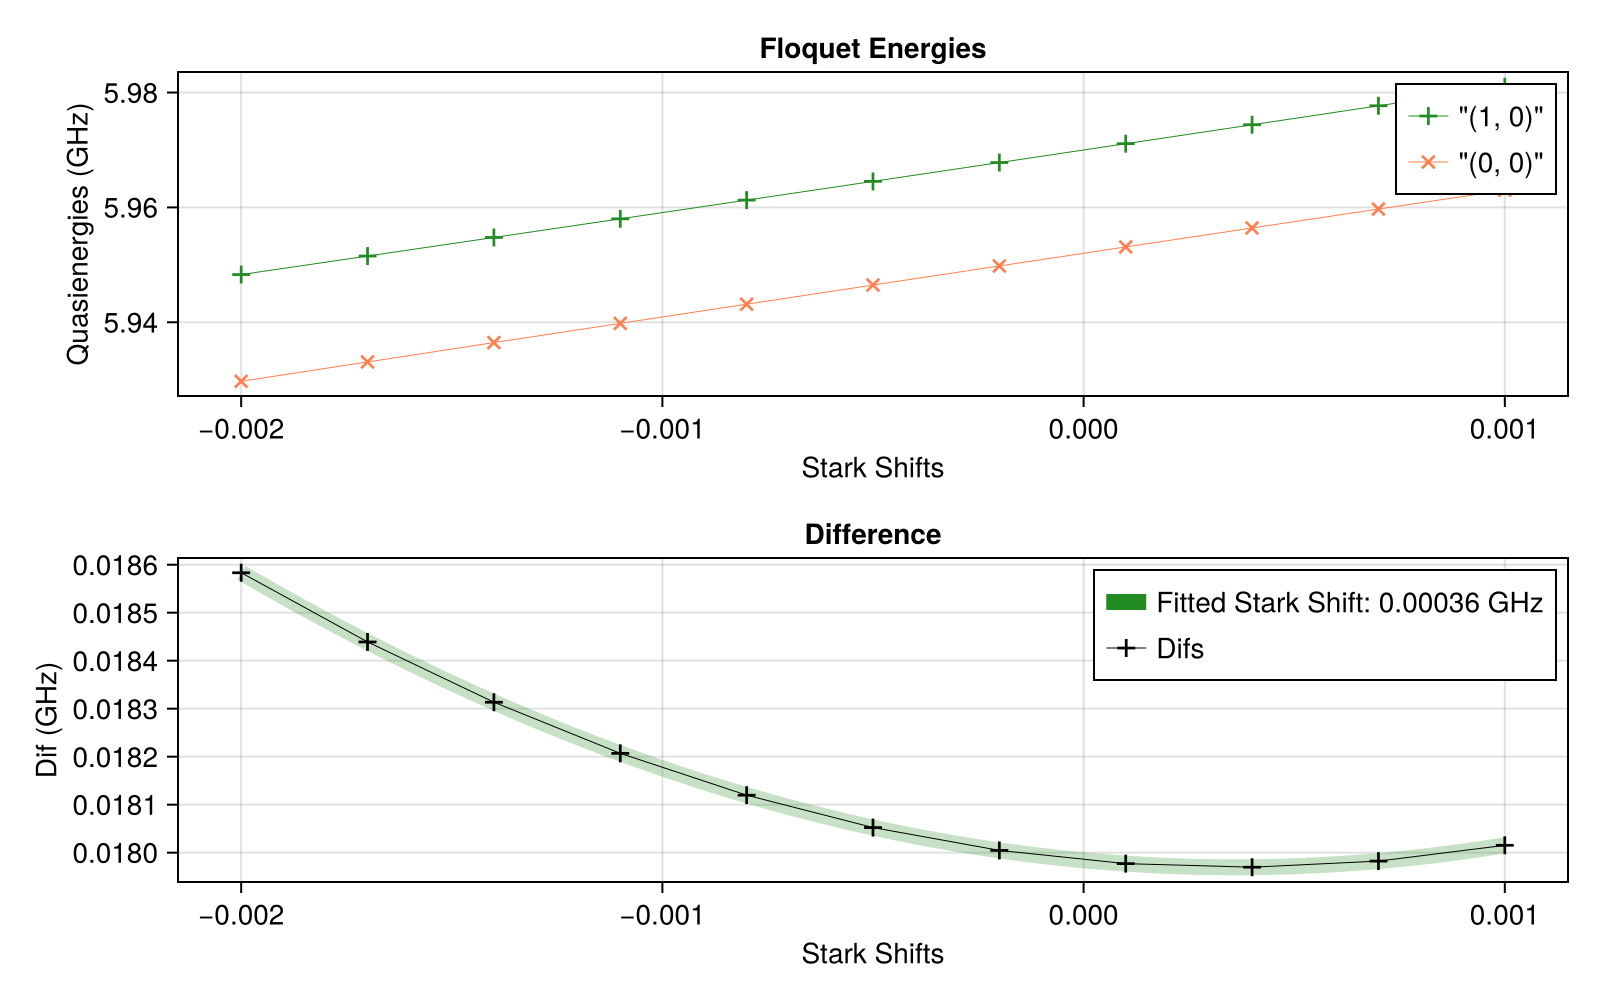

In [11]:
ge_ε = 0.00538
drive_op = Mode7.n̂ₜ
state1 = (0,0)
state2 = (1,0)

stark_shift_list = collect(LinRange(-0.002, 0.001, 11))

stark_shift_res = SC.Dynamics.FindStarkShift(Mode7, state1, state2, ge_ε, stark_shift_list)
println("Stark shift res: "*string(stark_shift_res))
ge_stark_shift = stark_shift_res[1];

#### $|1,0\rangle+|0,1\rangle \to |0,0\rangle+|1,1\rangle$

In [12]:

ψ1 = Mode7.dressed_states[(1,0)]+Mode7.dressed_states[(0,1)]
ψ1 = ψ1/qt.norm(ψ1)

ψ2 = Mode7.dressed_states[(0,0)]+Mode7.dressed_states[(1,1)]
ψ2 = ψ2/qt.norm(ψ2)

freq_d_e0 = Mode7.dressed_energies[(1,0)]-Mode7.dressed_energies[(0,0)]+ge_stark_shift
freq_d_g1 = Mode7.dressed_energies[(1,1)]-Mode7.dressed_energies[(0,1)]+ge_stark_shift

freq_d = (freq_d_e0+freq_d_g1)/2

check_op = proj_dict[(0,0)]+proj_dict[(1,1)]

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

#qubit_ε = qubit_ε

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge_half = SC.Dynamics.OptimizePulse(Mode7, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5, check_op = check_op)


[2024-11-10 19:57:44] Info: On Level 1
[2024-11-10 19:57:44] Info: On Step 1: t = 90.0
[2024-11-10 19:57:44] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-10 19:57:48] Info: Time Evolution Complete
[2024-11-10 19:57:48] Info: Done with Level_1_step_1
[2024-11-10 19:57:48] Info: Using Check Op
[2024-11-10 19:57:48] Info: Accurace: 0.9970629874445713
[2024-11-10 19:57:48] Info: ------------------------------------------------------------------------------
[2024-11-10 19:57:48] Info: On Step 2: t = 92.5
[2024-11-10 19:57:48] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-10 19:57:50] Info: Time Evolution Complete
[2024-11-10 19:57:50] Info: Done with Level_1_step_2
[2024-11-10 19:57:50] Info: Using Check Op
[2024-11-10 19:57:50] Info: Accurace: 0.9995041931022672
[2024-11-10 19:57:50] Info: ------------------------

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999567
  "freq_d"        => 4.60382

In [13]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode7.Stuff["op_drive_params"]["q_ge_1/2"] = deepcopy(qubit_ge_half)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999567
  "freq_d"        => 4.60382

In [14]:
ψ = Mode7.dressed_states[(1,0)]+Mode7.dressed_states[(0,1)]
ψ = ψ/qt.norm(ψ)
solver_kwargs = Dict{Any, Any}("abstol" => 1e-9, "reltol" => 1e-9)
q_ge_half_res = SC.Dynamics.RunPulseSequence(Mode7, ψ, ["q_ge_1/2"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-10T19:58:42.462
It is being saved at: Data/
[2024-11-10 19:58:42] Info: Running operator q_ge_1/2
[2024-11-10 19:58:42] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-10 19:58:45] Info: Time Evolution Complete
[2024-11-10 19:58:45] Info: Saving Steps
[2024-11-10 19:58:49] Info: Done with Step_1
[2024-11-10 19:58:49] Info: Done With Running Sequence
[2024-11-10 19:58:49] Info: Loading Data


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [15]:
EVs = SC.Utils.Get_EVs(q_ge_half_res["states"], proj_dict);

[2024-11-10 19:58:52] Info: Making Plot


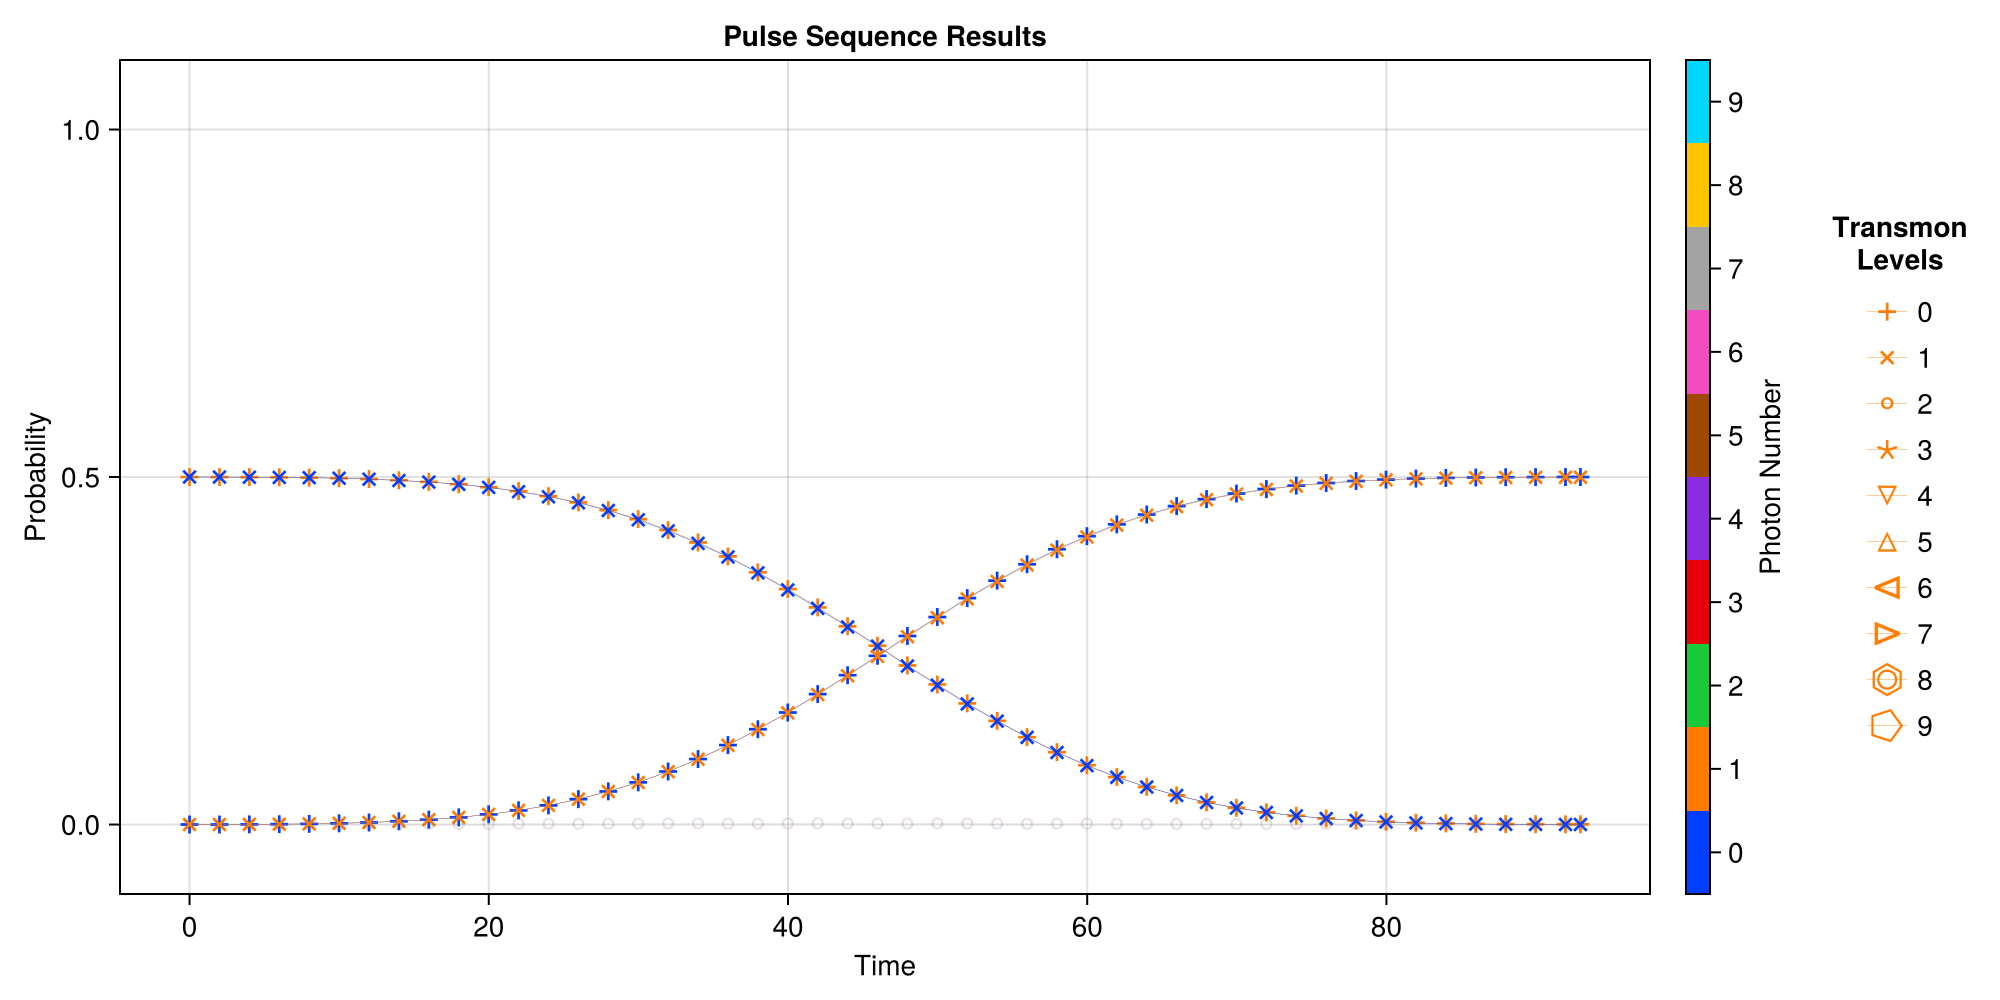

CairoMakie.Screen{IMAGE}


In [16]:
SC.Dynamics.PlotSingleModeEvolution(Mode7, q_ge_half_res["times"], EVs, plot_every = 10, emph_states = [(0,0),(1,0),(0,1),(1,1)])

In [17]:
println(EVs[(0,0)][end])
println(EVs[(1,1)][end])

0.49995893382506623 + 4.5512294704729504e-17im
0.49964167361294687 + 8.113402979095948e-18im


In [18]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999997366969875 + 5.3692683249738946e-17im

#### $|0,0\rangle \to |1,0\rangle$

In [19]:
state1 = (0,0)
state2 = (1,0)
ψ1 = Mode7.dressed_states[state1]
ψ2 = Mode7.dressed_states[state2]

freq_d = Mode7.dressed_energies[state2]-Mode7.dressed_energies[state1]+ge_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge0_opt_res = SC.Dynamics.OptimizePulse(Mode7, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-10 19:58:57] Info: On Level 1
[2024-11-10 19:58:57] Info: On Step 1: t = 90.0
[2024-11-10 19:58:57] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-10 19:59:00] Info: Time Evolution Complete
[2024-11-10 19:59:00] Info: Done with Level_1_step_1
[2024-11-10 19:59:00] Info: Accurace: 0.997022421414669
[2024-11-10 19:59:00] Info: ------------------------------------------------------------------------------
[2024-11-10 19:59:00] Info: On Step 2: t = 92.5
[2024-11-10 19:59:00] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-10 19:59:02] Info: Time Evolution Complete
[2024-11-10 19:59:02] Info: Done with Level_1_step_2
[2024-11-10 19:59:02] Info: Accurace: 0.9994682121431713
[2024-11-10 19:59:02] Info: ------------------------------------------------------------------------------
[2024-11-10 19:59:02] Info: On S

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999531
  "freq_d"        => 4.6039

In [20]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode7.Stuff["op_drive_params"]["q_ge_0"] = deepcopy(qubit_ge0_opt_res)
end


Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999531
  "freq_d"        => 4.6039

In [21]:
ψ = Mode7.dressed_states[(0,0)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-9, "reltol" => 1e-9)
q_ge0_res = SC.Dynamics.RunPulseSequence(Mode7, ψ, ["q_ge_0"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-10T19:59:55.902
It is being saved at: Data/
[2024-11-10 19:59:55] Info: Running operator q_ge_0
[2024-11-10 19:59:55] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-10 19:59:59] Info: Time Evolution Complete
[2024-11-10 19:59:59] Info: Saving Steps
[2024-11-10 20:00:00] Info: Done with Step_1
[2024-11-10 20:00:00] Info: Done With Running Sequence
[2024-11-10 20:00:00] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [22]:
EVs_ge0 = SC.Utils.Get_EVs(q_ge0_res["states"], proj_dict);

[2024-11-10 20:00:00] Info: Making Plot


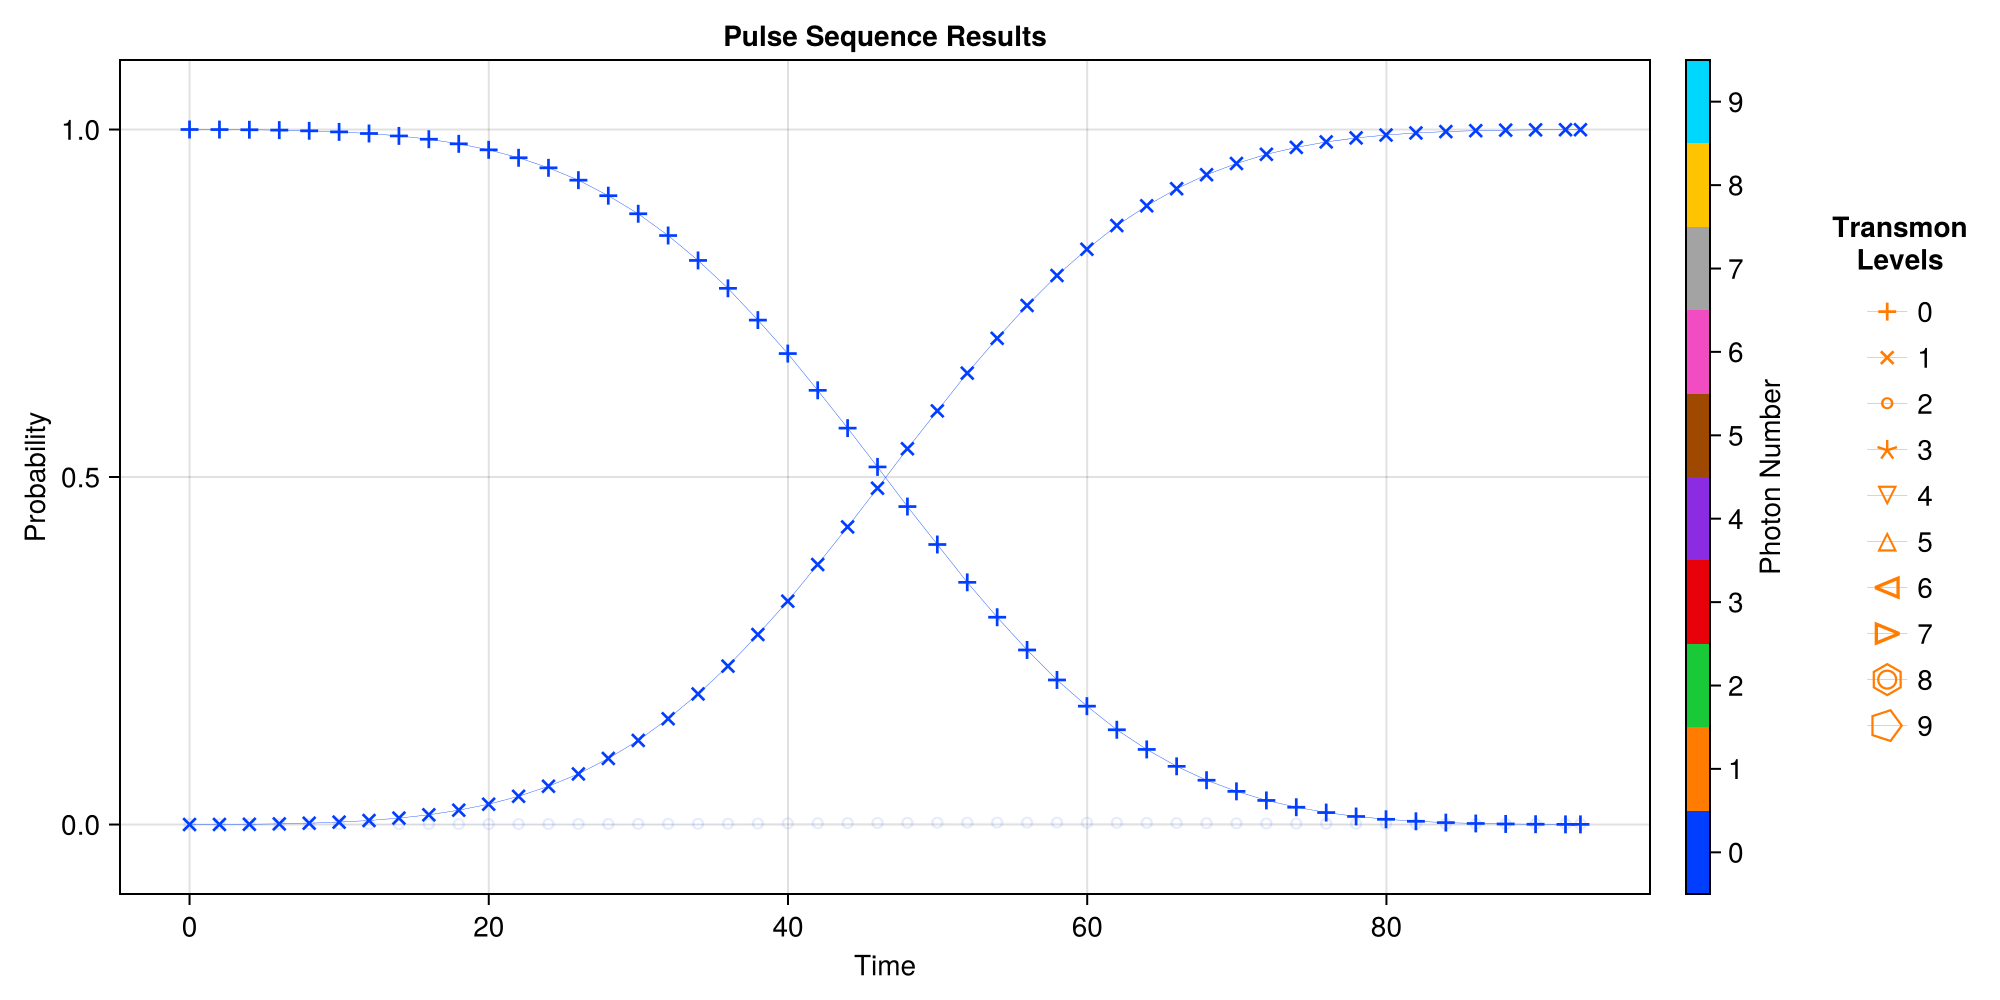

CairoMakie.Screen{IMAGE}


In [23]:
SC.Dynamics.PlotSingleModeEvolution(Mode7, q_ge0_res["times"], EVs_ge0, plot_every = 10, emph_states = [(0,0),(1,0)])

In [24]:
println(EVs_ge0[(0,0)][end])
println(EVs_ge0[(1,0)][end])
println(EVs_ge0[(2,0)][end])

0.00022509720165004454 + 1.1551929100493275e-20im
0.9997124065663011 + 7.216033891523594e-17im
6.209137659855982e-5 - 7.4619829653374795e-22im


In [25]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999997366969875 + 5.3692683249738946e-17im

#### $|0,1\rangle \to |1,1\rangle$

In [26]:
state1 = (0,1)
state2 = (1,1)
ψ1 = Mode7.dressed_states[state1]
ψ2 = Mode7.dressed_states[state2]

freq_d = Mode7.dressed_energies[state2]-Mode7.dressed_energies[state1]+ge_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)


t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge1_opt_res = SC.Dynamics.OptimizePulse(Mode7, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-10 20:00:01] Info: On Level 1
[2024-11-10 20:00:01] Info: On Step 1: t = 90.0
[2024-11-10 20:00:01] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-10 20:00:02] Info: Time Evolution Complete
[2024-11-10 20:00:02] Info: Done with Level_1_step_1
[2024-11-10 20:00:02] Info: Accurace: 0.9971950820741509
[2024-11-10 20:00:02] Info: ------------------------------------------------------------------------------
[2024-11-10 20:00:02] Info: On Step 2: t = 92.5
[2024-11-10 20:00:02] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-10 20:00:04] Info: Time Evolution Complete
[2024-11-10 20:00:04] Info: Done with Level_1_step_2
[2024-11-10 20:00:04] Info: Accurace: 0.9996461556716395
[2024-11-10 20:00:04] Info: ------------------------------------------------------------------------------
[2024-11-10 20:00:04] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.99971
  "freq_d"        => 4.60374

In [27]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode7.Stuff["op_drive_params"]["q_ge_1"] = deepcopy(qubit_ge1_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.99971
  "freq_d"        => 4.60374

In [28]:
ψ = Mode7.dressed_states[(0,1)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ge1_res = SC.Dynamics.RunPulseSequence(Mode7, ψ, ["q_ge_1"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-10T20:00:53.370
It is being saved at: Data/
[2024-11-10 20:00:53] Info: Running operator q_ge_1
[2024-11-10 20:00:53] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-10 20:00:55] Info: Time Evolution Complete
[2024-11-10 20:00:55] Info: Saving Steps
[2024-11-10 20:00:56] Info: Done with Step_1
[2024-11-10 20:00:56] Info: Done With Running Sequence
[2024-11-10 20:00:56] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [29]:
EVs = SC.Utils.Get_EVs(q_ge1_res["states"], proj_dict);

[2024-11-10 20:00:56] Info: Making Plot


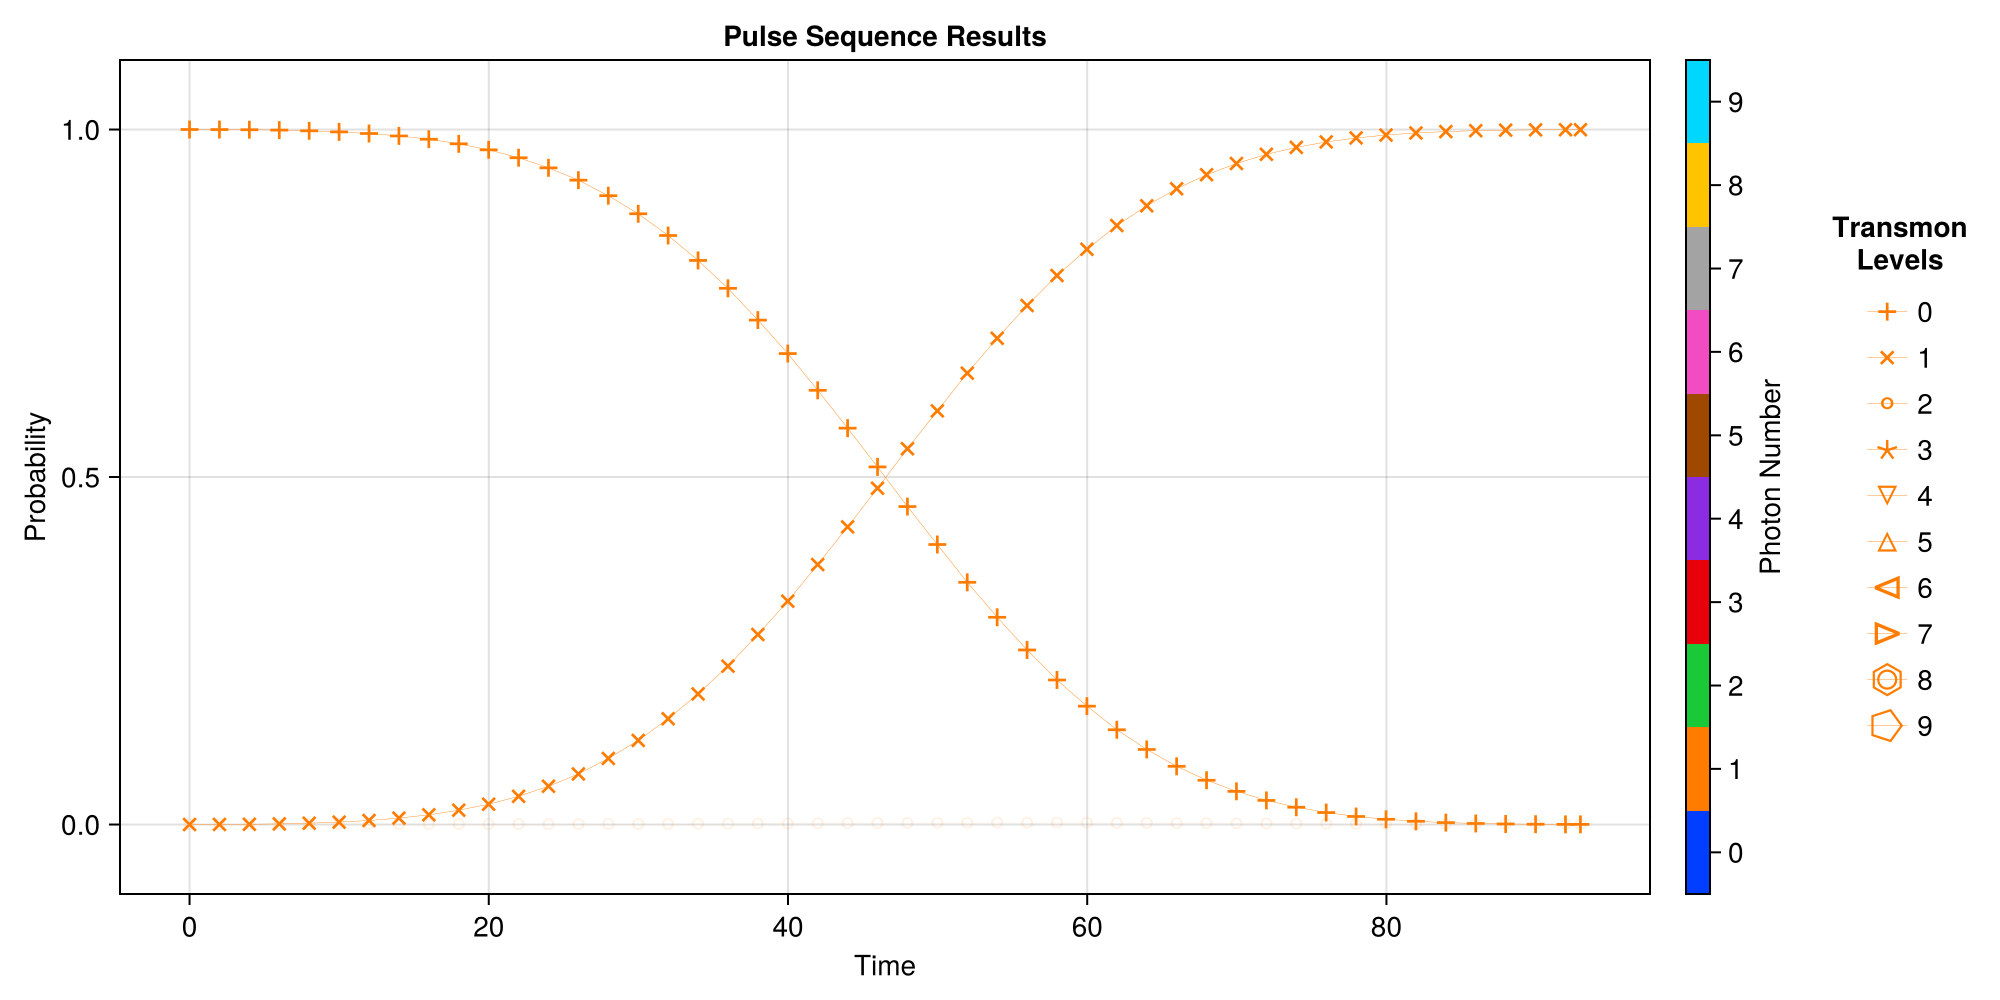

CairoMakie.Screen{IMAGE}


In [30]:
SC.Dynamics.PlotSingleModeEvolution(Mode7, q_ge1_res["times"], EVs, plot_every = 10, emph_states = [(0,1),(1,1)])

In [31]:
EVs[(1,1)][end]

0.9997108327074594 - 4.636434176914906e-17im

In [32]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999979532817106 - 4.618833761336807e-17im

#### $|0,0\rangle+(|1,1\rangle+|0,3\rangle)/\sqrt{2} \to |1,0\rangle+(|0,1\rangle+|1,3\rangle)/\sqrt{2}$

In [33]:

ψ1 = Mode7.dressed_states[(0,0)]+(Mode7.dressed_states[(1,1)]+Mode7.dressed_states[(0,3)])/sqrt(2)
ψ1 = ψ1/qt.norm(ψ1)

ψ2 = Mode7.dressed_states[(1,0)]+(Mode7.dressed_states[(0,1)]+Mode7.dressed_states[(1,3)])/sqrt(2)
ψ2 = ψ2/qt.norm(ψ2)

freq_d_g0 = Mode7.dressed_energies[(1,0)]-Mode7.dressed_energies[(0,0)]+ge_stark_shift
freq_d_g1 = Mode7.dressed_energies[(1,1)]-Mode7.dressed_energies[(0,1)]+ge_stark_shift
freq_d_g3 = Mode7.dressed_energies[(1,3)]-Mode7.dressed_energies[(0,3)]+ge_stark_shift

χ = freq_d_g1-freq_d_g0

freq_d = freq_d_g0+4*χ/3

check_op = proj_dict[(1,0)]+proj_dict[(0,1)]+proj_dict[(1,3)]

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)


t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge_four_thirds_opt_res = SC.Dynamics.OptimizePulse(Mode7, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5, check_op = check_op)


[2024-11-10 20:00:56] Info: On Level 1
[2024-11-10 20:00:56] Info: On Step 1: t = 90.0
[2024-11-10 20:00:56] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-10 20:00:58] Info: Time Evolution Complete
[2024-11-10 20:00:58] Info: Done with Level_1_step_1
[2024-11-10 20:00:58] Info: Using Check Op
[2024-11-10 20:00:58] Info: Accurace: 0.9966405518956275
[2024-11-10 20:00:58] Info: ------------------------------------------------------------------------------
[2024-11-10 20:00:58] Info: On Step 2: t = 92.5
[2024-11-10 20:00:58] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-10 20:01:00] Info: Time Evolution Complete
[2024-11-10 20:01:00] Info: Done with Level_1_step_2
[2024-11-10 20:01:00] Info: Using Check Op
[2024-11-10 20:01:00] Info: Accurace: 0.9990572422489732
[2024-11-10 20:01:00] Info: ------------------------

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999114
  "freq_d"        => 4.60369

In [34]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode7.Stuff["op_drive_params"]["q_ge_4/3"] = deepcopy(qubit_ge_four_thirds_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999114
  "freq_d"        => 4.60369

In [35]:
ψ = Mode7.dressed_states[(1,1)]+(Mode7.dressed_states[(0,0)]+Mode7.dressed_states[(0,3)])/sqrt(2)
ψ = ψ/qt.norm(ψ)
solver_kwargs = Dict{Any, Any}("abstol" => 1e-9, "reltol" => 1e-9)
q_ge_four_thirds_res = SC.Dynamics.RunPulseSequence(Mode7, ψ, ["q_ge_4/3"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-10T20:01:51.281
It is being saved at: Data/
[2024-11-10 20:01:51] Info: Running operator q_ge_4/3
[2024-11-10 20:01:51] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-10 20:01:55] Info: Time Evolution Complete
[2024-11-10 20:01:55] Info: Saving Steps
[2024-11-10 20:01:55] Info: Done with Step_1
[2024-11-10 20:01:55] Info: Done With Running Sequence
[2024-11-10 20:01:55] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [36]:
EVs = SC.Utils.Get_EVs(q_ge_four_thirds_res["states"], proj_dict);

[2024-11-10 20:01:55] Info: Making Plot


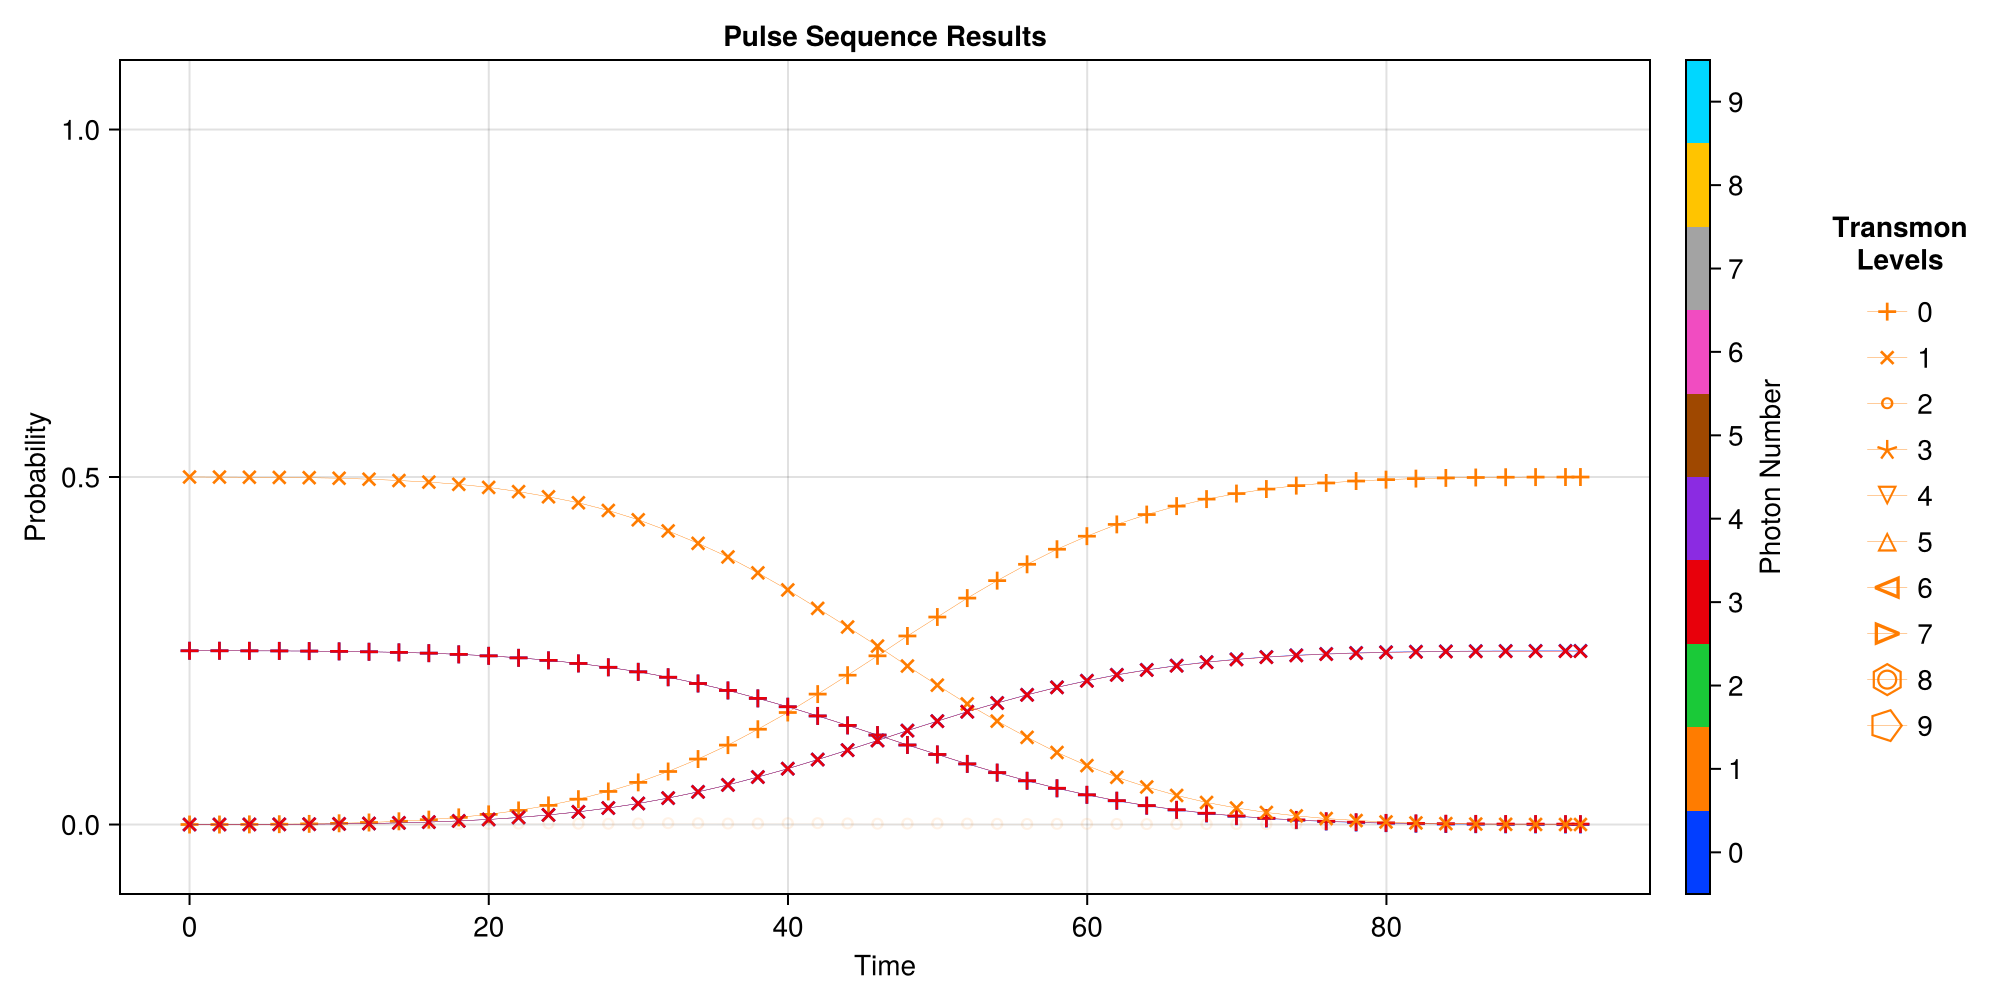

CairoMakie.Screen{IMAGE}


In [37]:
SC.Dynamics.PlotSingleModeEvolution(Mode7, q_ge_four_thirds_res["times"], EVs, plot_every = 10, emph_states = [(0,0),(1,0),(0,1),(1,1),(0,3),(1,3)])

In [38]:
println(EVs[(0,1)][end])
println(EVs[(1,0)][end])
println(EVs[(1,3)][end])

0.49993728457263503 - 1.0604135519565213e-16im
0.2499404888544567 - 5.5039371065347725e-18im
0.24935329990375293 - 1.408622784097847e-17im


In [39]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999998268427206 - 1.256902818106893e-16im

#### $|0,2\rangle \to |1,2\rangle$

In [40]:
state1 = (0,2)
state2 = (1,2)
ψ1 = Mode7.dressed_states[state1]
ψ2 = Mode7.dressed_states[state2]

freq_d = Mode7.dressed_energies[state2]-Mode7.dressed_energies[state1]+ge_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge2_opt_res = SC.Dynamics.OptimizePulse(Mode7, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-10 20:01:56] Info: On Level 1
[2024-11-10 20:01:56] Info: On Step 1: t = 90.0
[2024-11-10 20:01:56] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-10 20:01:57] Info: Time Evolution Complete
[2024-11-10 20:01:57] Info: Done with Level_1_step_1
[2024-11-10 20:01:57] Info: Accurace: 0.9971947262432792
[2024-11-10 20:01:57] Info: ------------------------------------------------------------------------------
[2024-11-10 20:01:57] Info: On Step 2: t = 92.5
[2024-11-10 20:01:57] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-10 20:02:00] Info: Time Evolution Complete
[2024-11-10 20:02:00] Info: Done with Level_1_step_2
[2024-11-10 20:02:00] Info: Accurace: 0.9996486484946038
[2024-11-10 20:02:00] Info: ------------------------------------------------------------------------------
[2024-11-10 20:02:00] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999713
  "freq_d"        => 4.60359

In [41]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode7.Stuff["op_drive_params"]["q_ge_2"] = deepcopy(qubit_ge2_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999713
  "freq_d"        => 4.60359

In [42]:
ψ = Mode7.dressed_states[(0, 2)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ge2_res = SC.Dynamics.RunPulseSequence(Mode7, ψ, ["q_ge_2"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-10T20:02:48.172
It is being saved at: Data/
[2024-11-10 20:02:48] Info: Running operator q_ge_2
[2024-11-10 20:02:48] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-10 20:02:50] Info: Time Evolution Complete
[2024-11-10 20:02:50] Info: Saving Steps
[2024-11-10 20:02:50] Info: Done with Step_1
[2024-11-10 20:02:50] Info: Done With Running Sequence
[2024-11-10 20:02:50] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [43]:
EVs = SC.Utils.Get_EVs(q_ge2_res["states"], proj_dict);

[2024-11-10 20:02:51] Info: Making Plot


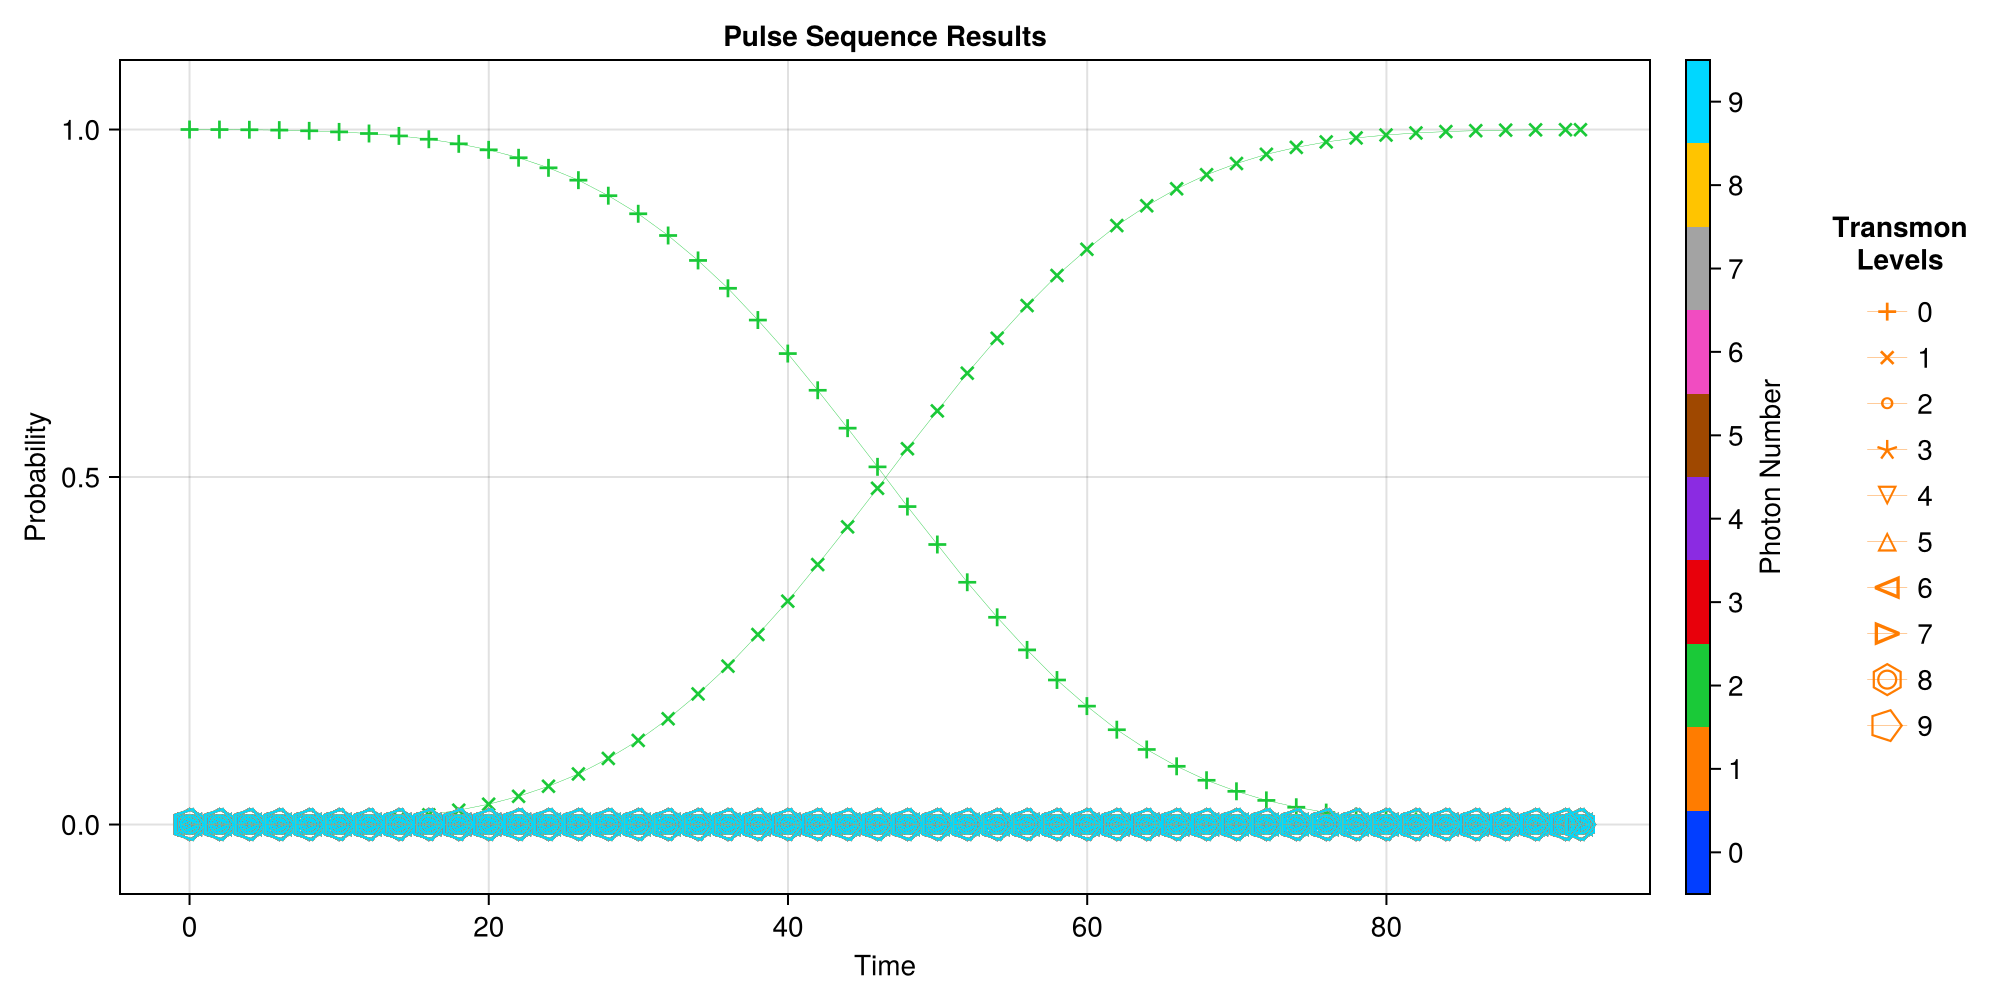

CairoMakie.Screen{IMAGE}


In [44]:
SC.Dynamics.PlotSingleModeEvolution(Mode7, q_ge2_res["times"], EVs, plot_every = 10)

In [45]:
EVs[(1,2)][end]

0.9997129191905263 - 2.443795121582656e-17im

In [46]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999999875432009 - 2.4477094348977696e-17im

#### $|0,3\rangle \to |1,3\rangle$

In [47]:
state1 = (0,3)
state2 = (1,3)
ψ1 = Mode7.dressed_states[state1]
ψ2 = Mode7.dressed_states[state2]

freq_d = Mode7.dressed_energies[state2]-Mode7.dressed_energies[state1]+ge_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge3_opt_res = SC.Dynamics.OptimizePulse(Mode7, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-10 20:02:51] Info: On Level 1
[2024-11-10 20:02:51] Info: On Step 1: t = 90.0
[2024-11-10 20:02:51] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-10 20:02:53] Info: Time Evolution Complete
[2024-11-10 20:02:53] Info: Done with Level_1_step_1
[2024-11-10 20:02:53] Info: Accurace: 0.9971912167359857
[2024-11-10 20:02:53] Info: ------------------------------------------------------------------------------
[2024-11-10 20:02:53] Info: On Step 2: t = 92.5
[2024-11-10 20:02:53] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-10 20:02:55] Info: Time Evolution Complete
[2024-11-10 20:02:55] Info: Done with Level_1_step_2
[2024-11-10 20:02:55] Info: Accurace: 0.9996480773238163
[2024-11-10 20:02:55] Info: ------------------------------------------------------------------------------
[2024-11-10 20:02:55] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999713
  "freq_d"        => 4.60344

In [48]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode7.Stuff["op_drive_params"]["q_ge_3"] = deepcopy(qubit_ge3_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999713
  "freq_d"        => 4.60344

In [49]:
ψ = Mode7.dressed_states[(0, 3)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ge3_res = SC.Dynamics.RunPulseSequence(Mode7, ψ, ["q_ge_3"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-10T20:03:53.460
It is being saved at: Data/
[2024-11-10 20:03:53] Info: Running operator q_ge_3
[2024-11-10 20:03:53] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-10 20:03:55] Info: Time Evolution Complete
[2024-11-10 20:03:55] Info: Saving Steps
[2024-11-10 20:03:56] Info: Done with Step_1
[2024-11-10 20:03:56] Info: Done With Running Sequence
[2024-11-10 20:03:56] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [50]:
EVs = SC.Utils.Get_EVs(q_ge3_res["states"], proj_dict);

[2024-11-10 20:03:56] Info: Making Plot


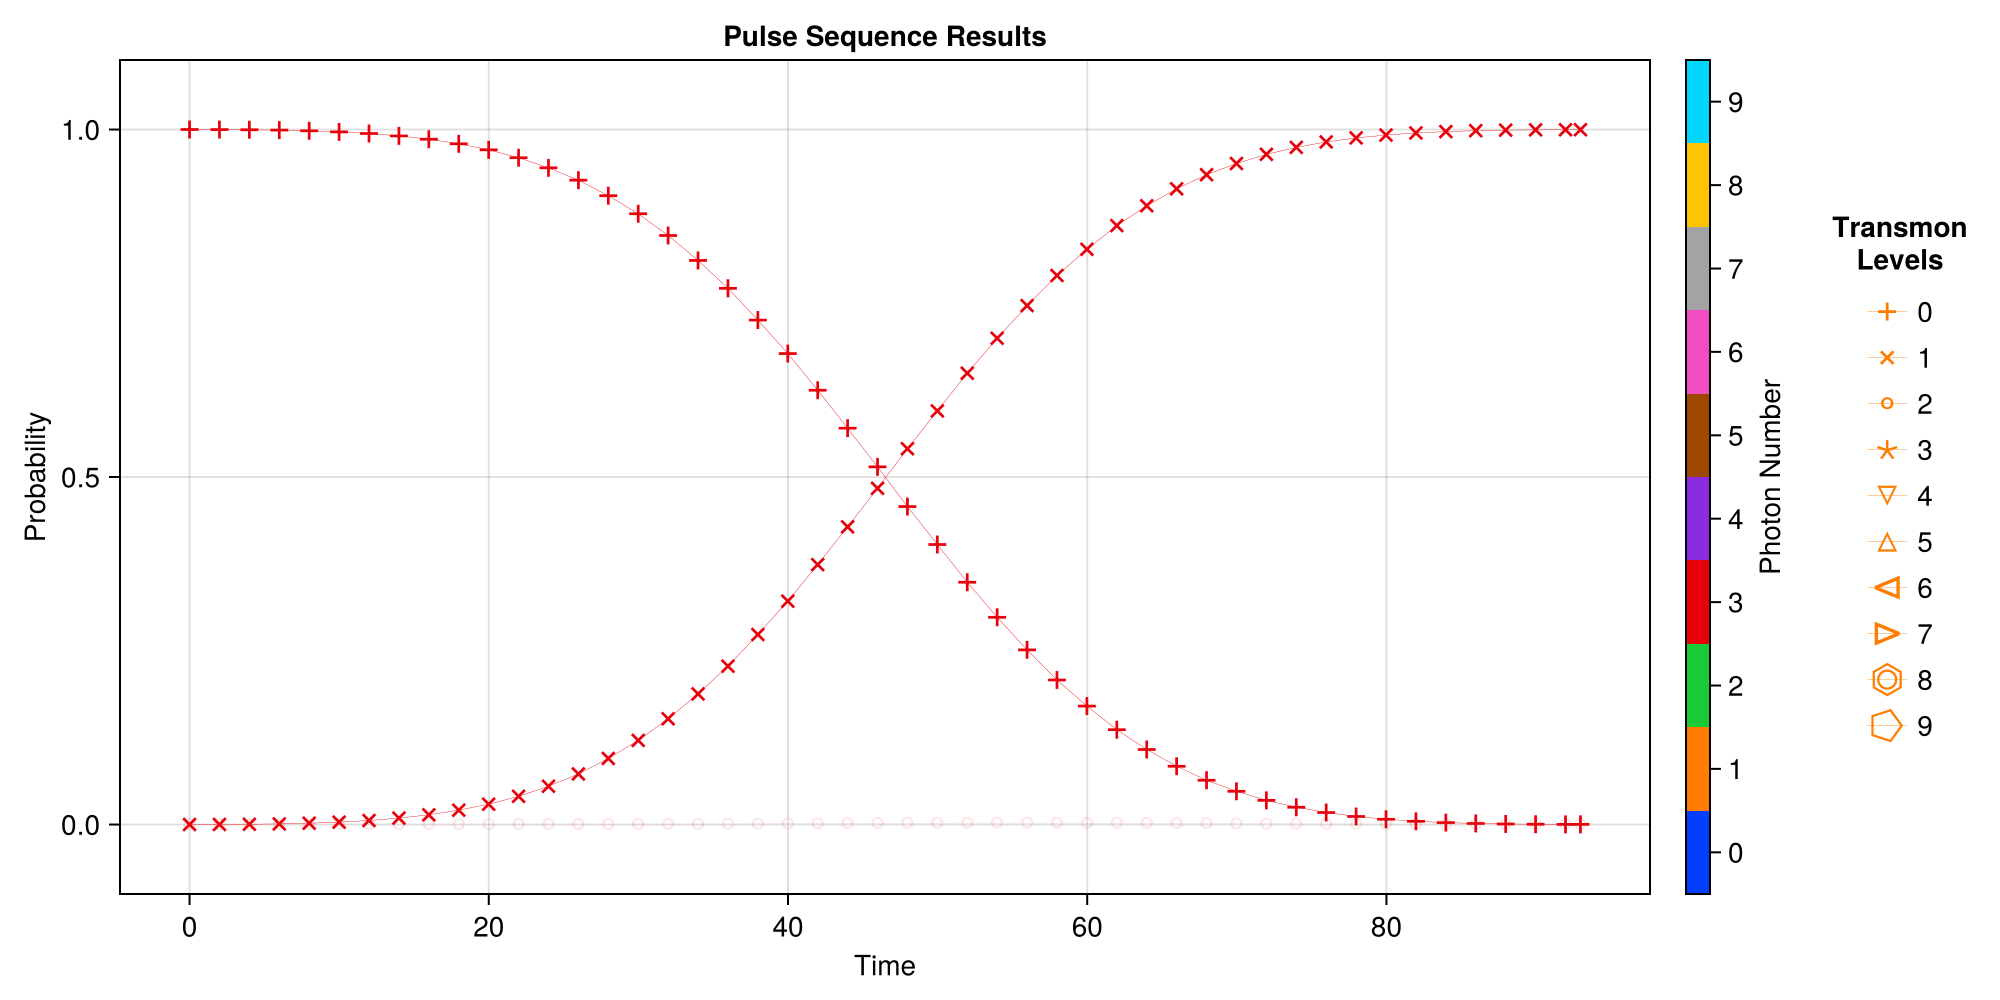

CairoMakie.Screen{IMAGE}


In [51]:
SC.Dynamics.PlotSingleModeEvolution(Mode7, q_ge3_res["times"], EVs, plot_every = 10, emph_states = [(0,3),(1,3)])

In [52]:
EVs[(1,3)][end]

0.9997129648450312 - 6.406862008368317e-18im

In [53]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999999996160912 - 6.262327666859189e-18im

### Guassian e -> f

In [54]:
println("Target σ: "*string(device_config["device"]["soc"]["qubit"]["pulses"]["pi_ef"]["sigma"]))

Target σ: 0.023251488095238096


##### Getting Stark Shift

[2024-11-10 20:03:56] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


[2024-11-10 20:04:01] Info: Done With Floquet Sweep
[2024-11-10 20:04:01] Info: Fit Stuff: 3-element Vector{Float64}:	 0.00016525027892344446	 0.008957319402973129	 2.0062830177540416
Stark shift res: [0.00016525027892344446, 55.645460681206636]


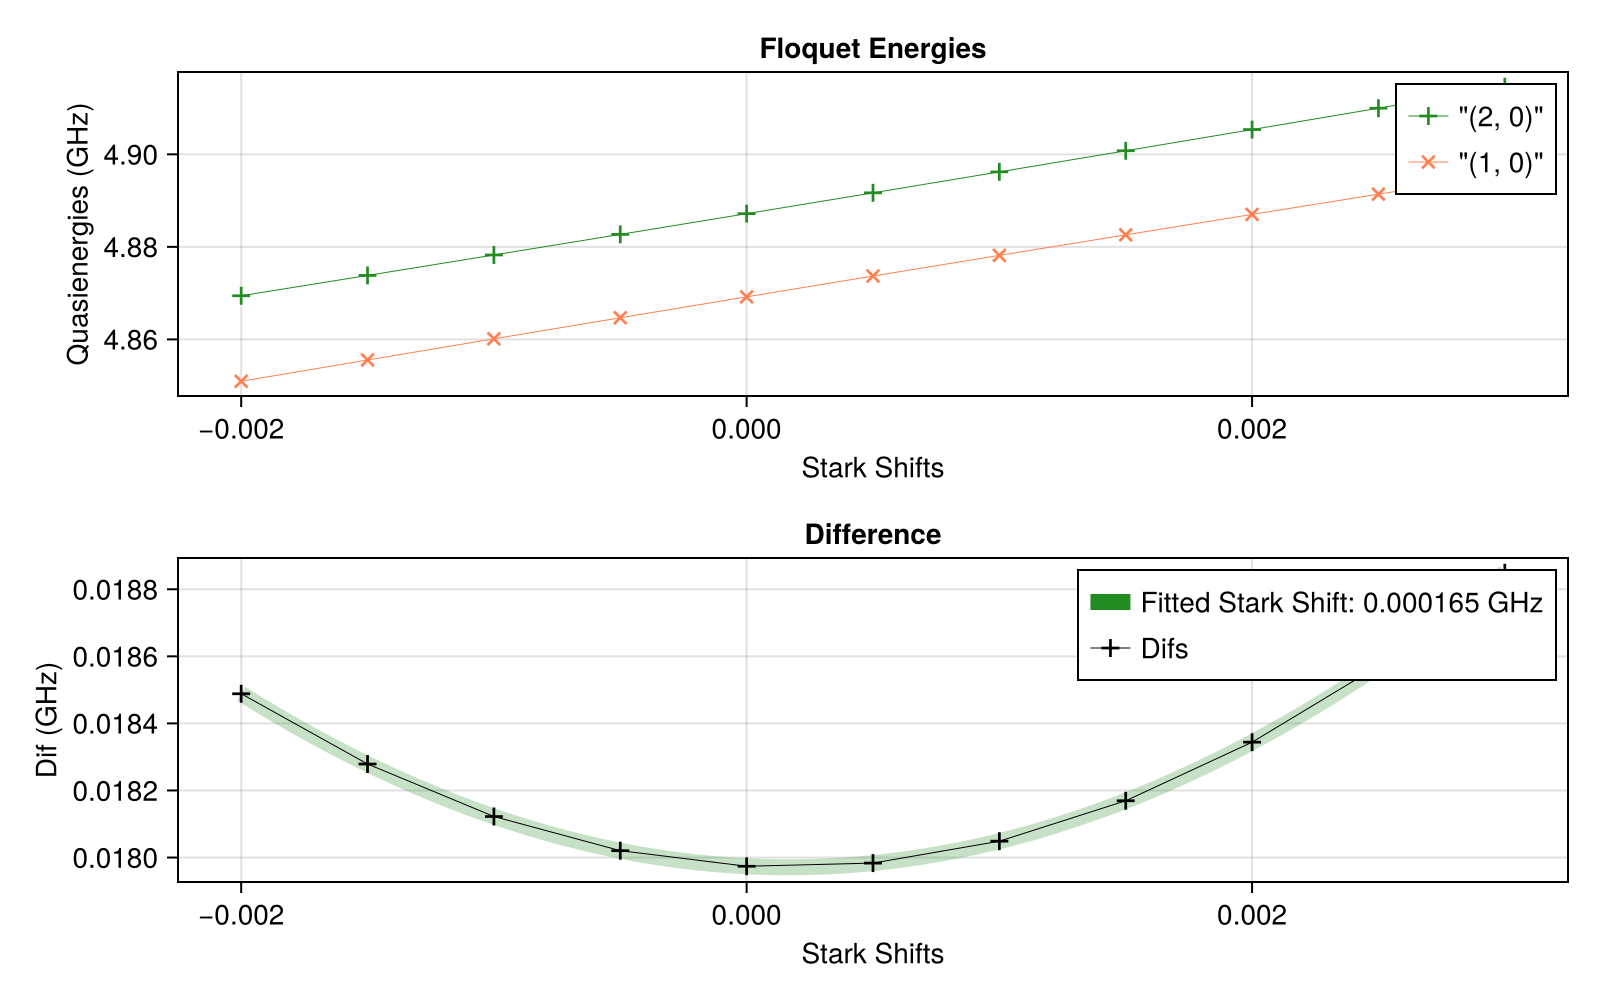

In [55]:
ef_ε = 0.00385
drive_op = Mode7.n̂ₜ
state1 = (1,0)
state2 = (2,0)

stark_shift_list = collect(LinRange(-0.002, 0.003, 11))

stark_shift_res = SC.Dynamics.FindStarkShift(Mode7, state1, state2, ef_ε, stark_shift_list)
println("Stark shift res: "*string(stark_shift_res))

ef_stark_shift = stark_shift_res[1];

##### $|1,0\rangle \to |2,0\rangle$

In [56]:
state1 = (1,0)
state2 = (2,0)
ψ1 = Mode7.dressed_states[state1]
ψ2 = Mode7.dressed_states[state2]

freq_d = Mode7.dressed_energies[state2]-Mode7.dressed_energies[state1] + ef_stark_shift


envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]

qubit_ef0_opt_res = SC.Dynamics.OptimizePulse(Mode7, ψ1, ψ2, ef_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-10 20:04:01] Info: On Level 1
[2024-11-10 20:04:01] Info: On Step 1: t = 90.0
[2024-11-10 20:04:01] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-10 20:04:04] Info: Time Evolution Complete
[2024-11-10 20:04:04] Info: Done with Level_1_step_1
[2024-11-10 20:04:04] Info: Accurace: 0.9973581320807213
[2024-11-10 20:04:04] Info: ------------------------------------------------------------------------------
[2024-11-10 20:04:04] Info: On Step 2: t = 92.5
[2024-11-10 20:04:04] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-10 20:04:06] Info: Time Evolution Complete
[2024-11-10 20:04:06] Info: Done with Level_1_step_2
[2024-11-10 20:04:06] Info: Accurace: 0.9998184400205689
[2024-11-10 20:04:06] Info: ------------------------------------------------------------------------------
[2024-11-10 20:04:06] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.99988
  "freq_d"        => 4.49542

In [57]:
#Mode7.Stuff["op_drive_params"]["q_ef_0"] = deepcopy(qubit_ef0_opt_res)
if GLOBAL_SAVE_CALIBRATE | false
    Mode7.Stuff["op_drive_params"]["q_ef_0"] = deepcopy(qubit_ef0_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.99988
  "freq_d"        => 4.49542

In [58]:
ψ = Mode7.dressed_states[(1,0)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ef0_res = SC.Dynamics.RunPulseSequence(Mode7, ψ, ["q_ef_0"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-10T20:05:25.398
It is being saved at: Data/
[2024-11-10 20:05:25] Info: Running operator q_ef_0
[2024-11-10 20:05:25] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-11-10 20:05:29] Info: Time Evolution Complete
[2024-11-10 20:05:29] Info: Saving Steps
[2024-11-10 20:05:30] Info: Done with Step_1
[2024-11-10 20:05:30] Info: Done With Running Sequence
[2024-11-10 20:05:30] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [59]:
EVs_ef0 = SC.Utils.Get_EVs(q_ef0_res["states"], proj_dict);

[2024-11-10 20:05:30] Info: Making Plot


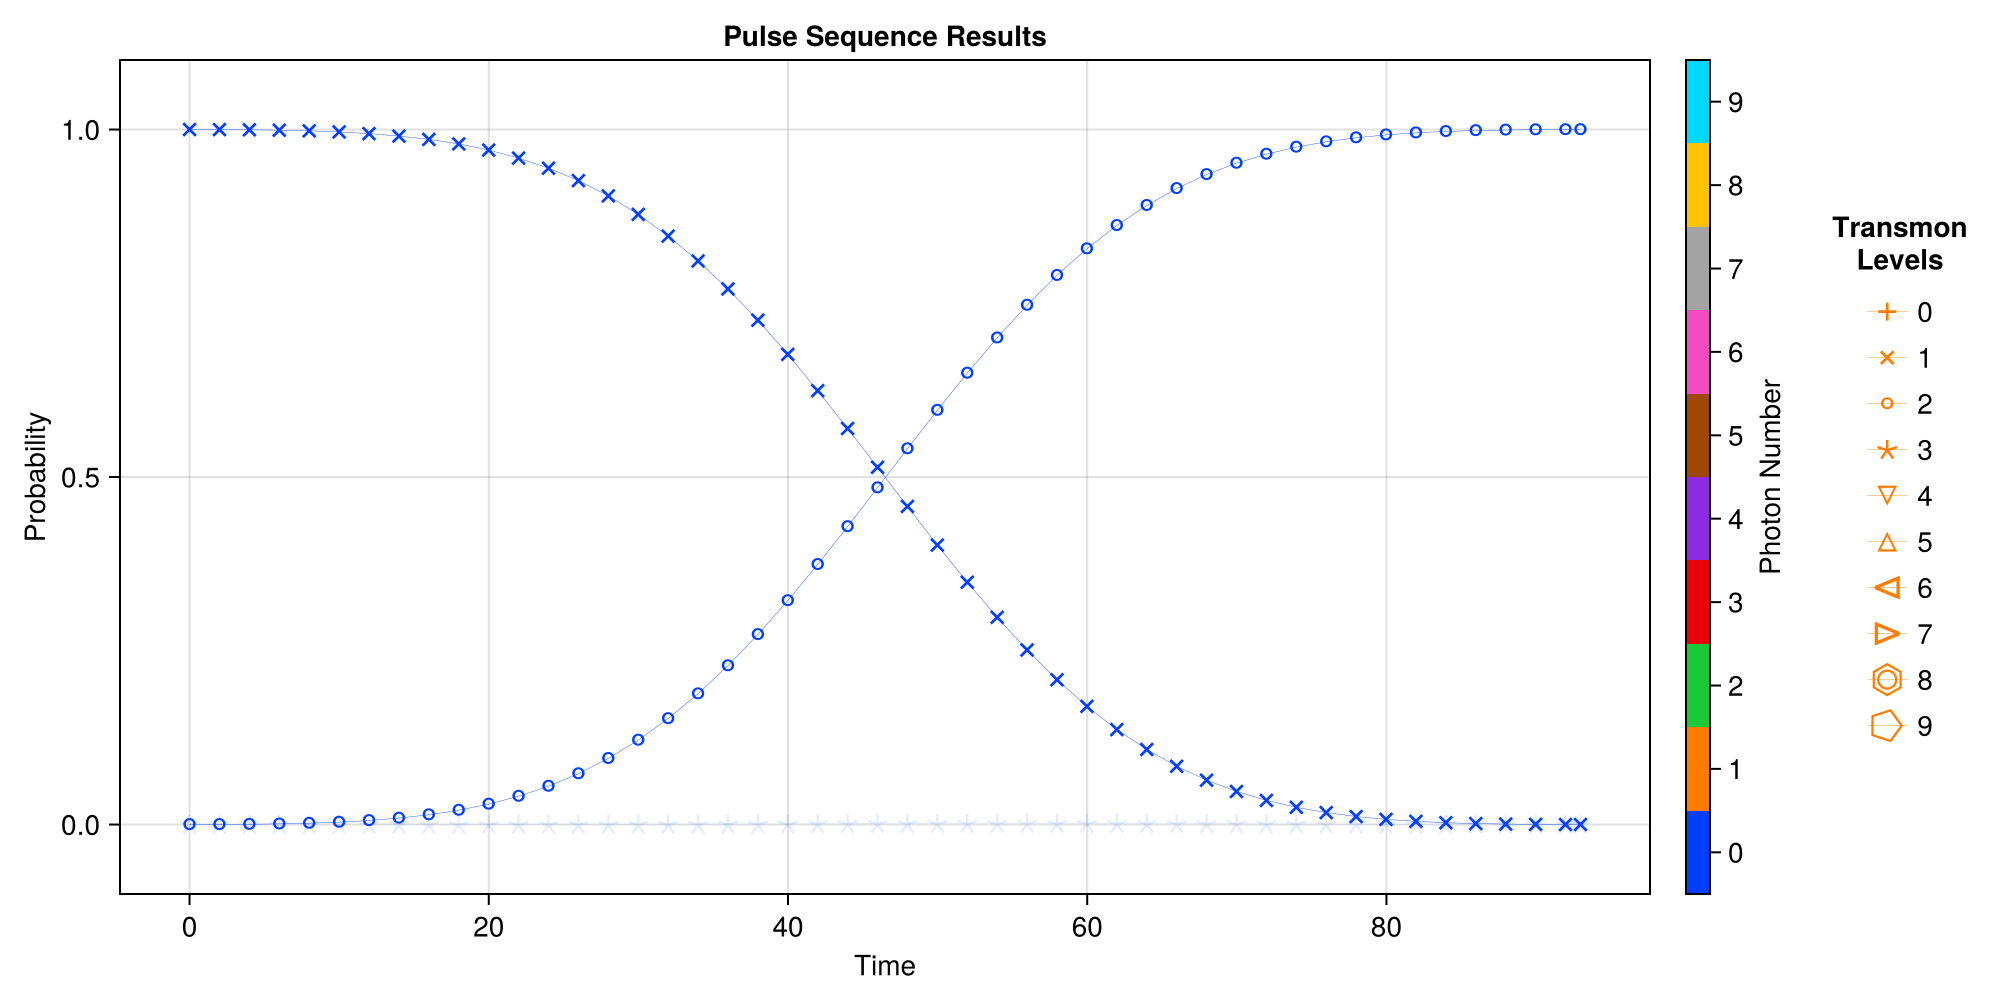

CairoMakie.Screen{IMAGE}


In [60]:
SC.Dynamics.PlotSingleModeEvolution(Mode7, q_ef0_res["times"], EVs_ef0, plot_every = 10, emph_states = [(1,0),(2,0)])

In [61]:
println(EVs_ef0[(0,0)][end])
println(EVs_ef0[(1,0)][end])
println(EVs_ef0[(2,0)][end])
println(EVs_ef0[(3,0)][end])

1.57867377478504e-5 - 3.8667861219648403e-22im
4.6954933629127654e-5 + 3.51985564406917e-21im
0.9998918005951897 + 1.1208594128432366e-16im
4.274869933813066e-5 + 2.469157472215201e-23im


In [62]:
tot = 0
for key in keys(EVs_ef0)
    tot+=EVs_ef0[key][end]
end
print(tot)

0.9999972912163333 + 1.1225661843558656e-16im

##### $|1,1\rangle \to |2,1\rangle$

In [63]:
state1 = (1,1)
state2 = (2,1)
ψ1 = Mode7.dressed_states[state1]
ψ2 = Mode7.dressed_states[state2]

freq_d = Mode7.dressed_energies[state2]-Mode7.dressed_energies[state1]+ef_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]

qubit_ef1_opt_res = SC.Dynamics.OptimizePulse(Mode7, ψ1, ψ2, ef_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-10 20:05:31] Info: On Level 1
[2024-11-10 20:05:31] Info: On Step 1: t = 90.0
[2024-11-10 20:05:31] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-10 20:05:34] Info: Time Evolution Complete
[2024-11-10 20:05:34] Info: Done with Level_1_step_1
[2024-11-10 20:05:34] Info: Accurace: 0.9973695069199917
[2024-11-10 20:05:34] Info: ------------------------------------------------------------------------------
[2024-11-10 20:05:34] Info: On Step 2: t = 92.5
[2024-11-10 20:05:34] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-11-10 20:05:38] Info: Time Evolution Complete
[2024-11-10 20:05:38] Info: Done with Level_1_step_2
[2024-11-10 20:05:38] Info: Accurace: 0.9998316695380749
[2024-11-10 20:05:38] Info: ------------------------------------------------------------------------------
[2024-11-10 20:05:38] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999894
  "freq_d"        => 4.49528

In [64]:
#Mode7.Stuff["op_drive_params"]["q_ef_1"] = deepcopy(qubit_ef1_opt_res)
if GLOBAL_SAVE_CALIBRATE | false
    Mode7.Stuff["op_drive_params"]["q_ef_1"] = deepcopy(qubit_ef1_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999894
  "freq_d"        => 4.49528

In [65]:
ψ = Mode7.dressed_states[(1,1)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ef1_res = SC.Dynamics.RunPulseSequence(Mode7, ψ, ["q_ef_1"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-10T20:06:41.912
It is being saved at: Data/
[2024-11-10 20:06:41] Info: Running operator q_ef_1
[2024-11-10 20:06:41] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-10 20:06:45] Info: Time Evolution Complete
[2024-11-10 20:06:45] Info: Saving Steps
[2024-11-10 20:06:46] Info: Done with Step_1
[2024-11-10 20:06:46] Info: Done With Running Sequence
[2024-11-10 20:06:46] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [66]:
EVs = SC.Utils.Get_EVs(q_ef1_res["states"], proj_dict);

[2024-11-10 20:06:46] Info: Making Plot


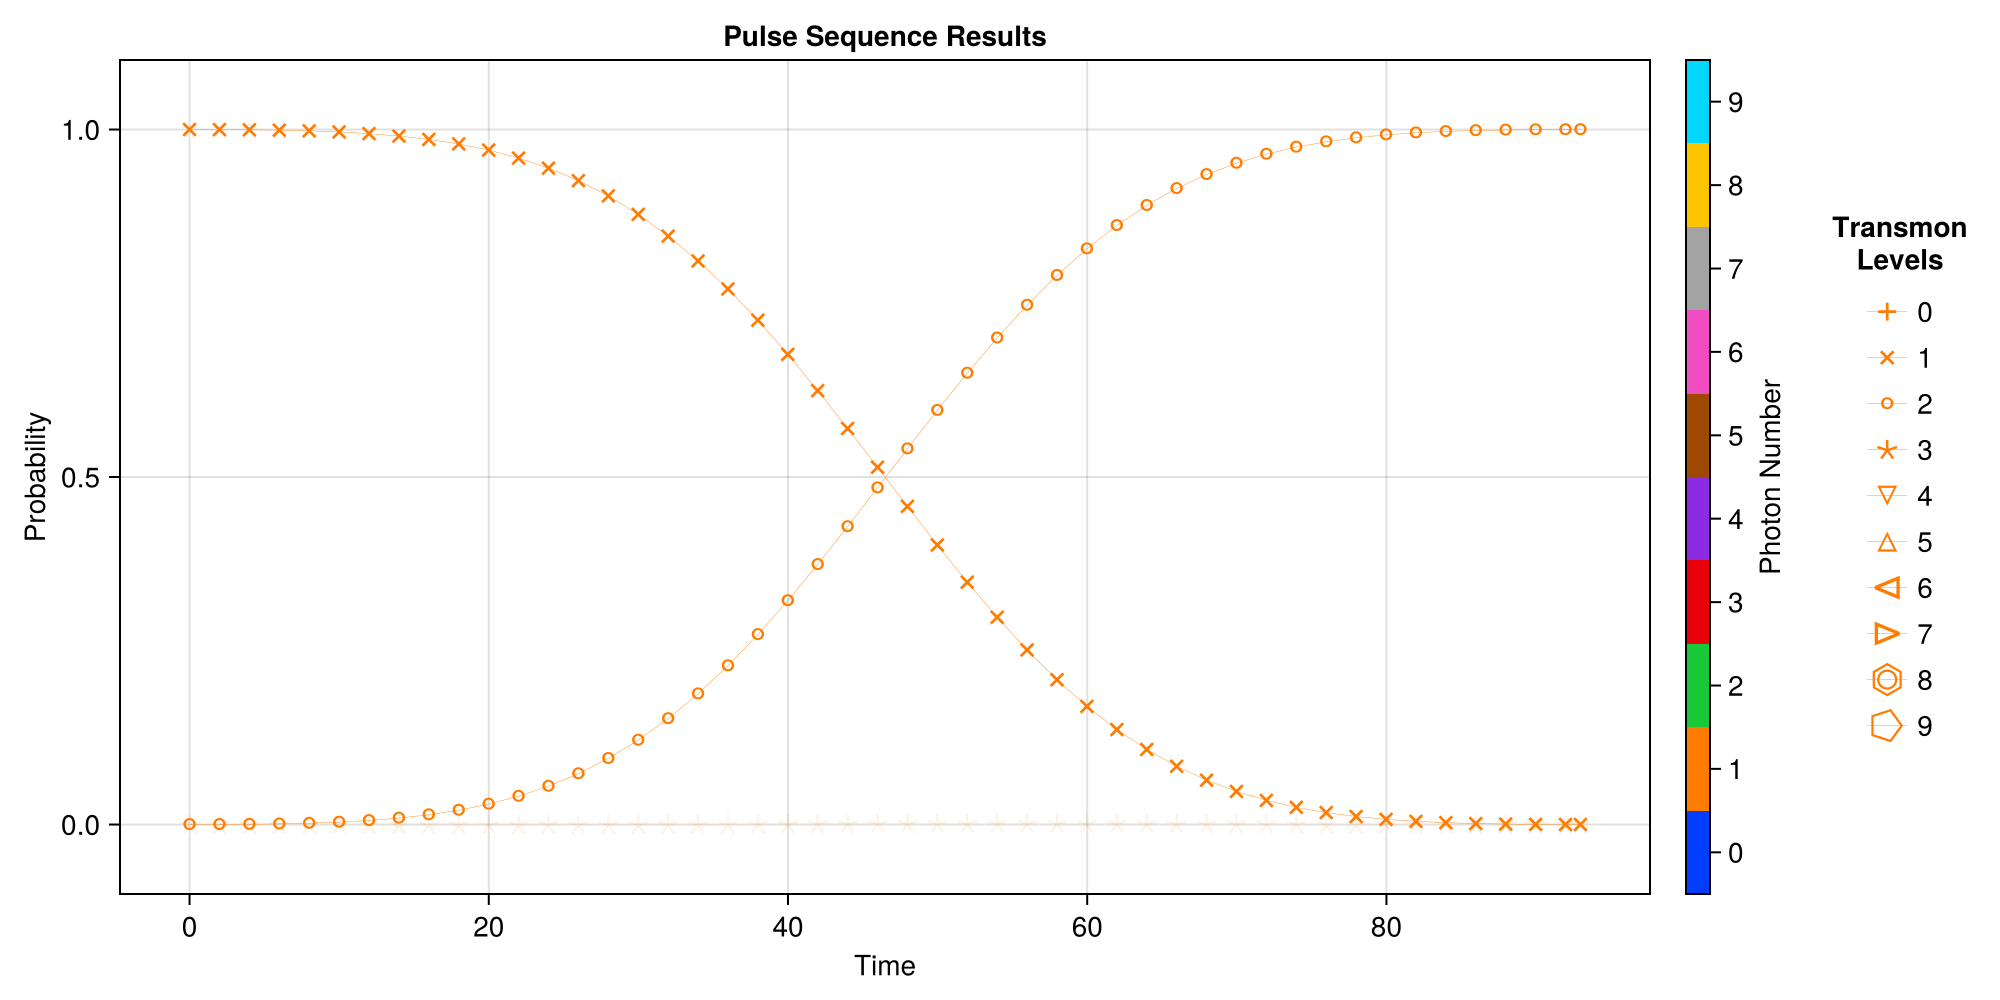

CairoMakie.Screen{IMAGE}


In [67]:
SC.Dynamics.PlotSingleModeEvolution(Mode7, q_ef1_res["times"], EVs, plot_every = 10, emph_states = [(1,1),(2,1)])

In [68]:
EVs[(2,1)][end]

0.9998944433047432 + 5.890291095430735e-17im

In [69]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999999067407642 + 5.912089599937918e-17im

##### $|1,0\rangle+\frac{1}{\sqrt{2}}\left(|2,0\rangle + |1, 3\rangle\right)\to |2,0\rangle+\frac{1}{\sqrt{2}}\left(|1,0\rangle + |2, 3\rangle\right)$

In [70]:
ψ1 = Mode7.dressed_states[(1,0)]/sqrt(2)+Mode7.dressed_states[(2,0)]+Mode7.dressed_states[(1,3)]/sqrt(2)
ψ1 = ψ1/qt.norm(ψ1)

ψ2 = Mode7.dressed_states[(2,0)]+(Mode7.dressed_states[(1,0)]+Mode7.dressed_states[(2,3)])/sqrt(2)
ψ2 = ψ2/qt.norm(ψ2)

freq_d_ef0 = Mode7.dressed_energies[(2,0)]-Mode7.dressed_energies[(1,0)]+ef_stark_shift
freq_d_ef1 = Mode7.dressed_energies[(2,1)]-Mode7.dressed_energies[(1,1)]+ef_stark_shift
freq_d_ef3 = Mode7.dressed_energies[(2,3)]-Mode7.dressed_energies[(1,3)]+ef_stark_shift

χ = freq_d_ef1-freq_d_ef0

freq_d = freq_d_ef0+3*χ/2

check_op = proj_dict[(2,0)]+proj_dict[(1,0)]+proj_dict[(2,3)]

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ef_three_halves_opt_res = SC.Dynamics.OptimizePulse(Mode7, ψ1, ψ2, ef_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5, check_op = check_op)

[2024-11-10 20:06:47] Info: On Level 1
[2024-11-10 20:06:47] Info: On Step 1: t = 90.0
[2024-11-10 20:06:47] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-11-10 20:06:51] Info: Time Evolution Complete
[2024-11-10 20:06:51] Info: Done with Level_1_step_1
[2024-11-10 20:06:51] Info: Using Check Op
[2024-11-10 20:06:51] Info: Accurace: 0.9990213755750843
[2024-11-10 20:06:51] Info: ------------------------------------------------------------------------------
[2024-11-10 20:06:51] Info: On Step 2: t = 92.5
[2024-11-10 20:06:51] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-10 20:06:54] Info: Time Evolution Complete
[2024-11-10 20:06:54] Info: Done with Level_1_step_2
[2024-11-10 20:06:54] Info: Using Check Op
[2024-11-10 20:06:54] Info: Accurace: 0.9995549061482858
[2024-11-10 20:06:54] Info: ------------------------

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999563
  "freq_d"        => 4.4952

In [71]:
#Mode7.Stuff["op_drive_params"]["q_ef_3/2"] = deepcopy(qubit_ef_three_halves_opt_res)
if GLOBAL_SAVE_CALIBRATE | false
    Mode7.Stuff["op_drive_params"]["q_ef_3/2"] = deepcopy(qubit_ef_three_halves_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999563
  "freq_d"        => 4.4952

In [72]:
ψ = Mode7.dressed_states[(1,0)]/sqrt(2)+Mode7.dressed_states[(2,0)]+Mode7.dressed_states[(1,3)]/sqrt(2)
ψ = ψ/qt.norm(ψ)
solver_kwargs = Dict{Any, Any}("abstol" => 1e-9, "reltol" => 1e-9)
q_ef_three_halves_res = SC.Dynamics.RunPulseSequence(Mode7, ψ, ["q_ef_3/2"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-10T20:08:20.569
It is being saved at: Data/
[2024-11-10 20:08:20] Info: Running operator q_ef_3/2
[2024-11-10 20:08:20] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-11-10 20:08:25] Info: Time Evolution Complete
[2024-11-10 20:08:25] Info: Saving Steps
[2024-11-10 20:08:26] Info: Done with Step_1
[2024-11-10 20:08:26] Info: Done With Running Sequence
[2024-11-10 20:08:26] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [73]:
EVs = SC.Utils.Get_EVs(q_ef_three_halves_res["states"], proj_dict);

[2024-11-10 20:08:26] Info: Making Plot


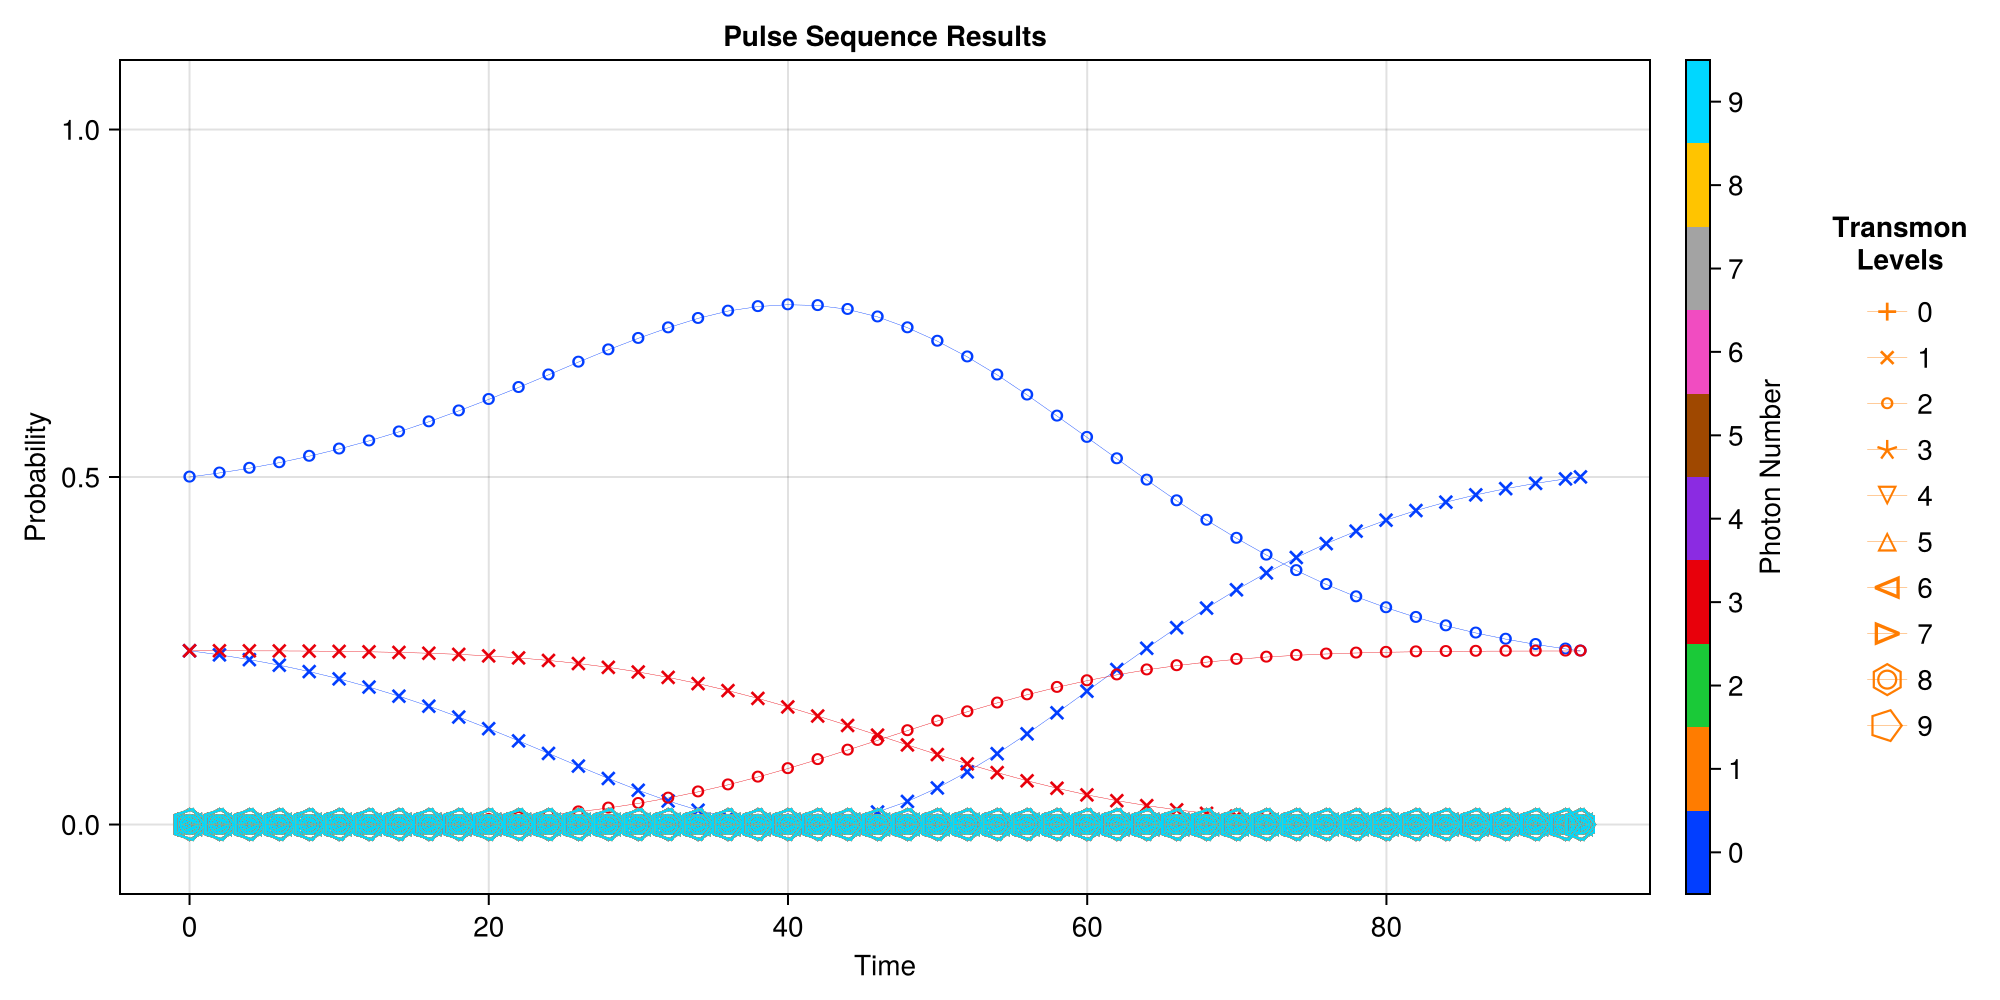

CairoMakie.Screen{IMAGE}


In [74]:
SC.Dynamics.PlotSingleModeEvolution(Mode7, q_ef_three_halves_res["times"], EVs, plot_every = 10)

In [75]:
println(EVs[(2,0)][end])
println(EVs[(1,0)][end])
println(EVs[(2,3)][end])

0.24979163179587108 + 6.133816721408865e-18im
0.5001250948142612 - 9.225319374539256e-17im
0.24965099509879413 - 7.459745411104787e-18im


In [76]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999998244635281 - 9.339561714457914e-17im

##### $|1,2\rangle \to |2,2\rangle$

In [77]:
state1 = (1,2)
state2 = (2,2)
ψ1 = Mode7.dressed_states[state1]
ψ2 = Mode7.dressed_states[state2]

freq_d = Mode7.dressed_energies[state2]-Mode7.dressed_energies[state1]+ef_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]

qubit_ef2_opt_res = SC.Dynamics.OptimizePulse(Mode7, ψ1, ψ2, ef_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 7)


[2024-11-10 20:08:27] Info: On Level 1
[2024-11-10 20:08:27] Info: On Step 1: t = 90.0
[2024-11-10 20:08:27] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-11-10 20:08:31] Info: Time Evolution Complete
[2024-11-10 20:08:31] Info: Done with Level_1_step_1
[2024-11-10 20:08:31] Info: Accurace: 0.9973677026037532
[2024-11-10 20:08:31] Info: ------------------------------------------------------------------------------
[2024-11-10 20:08:31] Info: On Step 2: t = 92.5
[2024-11-10 20:08:31] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-10 20:08:34] Info: Time Evolution Complete
[2024-11-10 20:08:35] Info: Done with Level_1_step_2
[2024-11-10 20:08:35] Info: Accurace: 0.9998312874729205
[2024-11-10 20:08:35] Info: ------------------------------------------------------------------------------
[2024-11-10 20:08:35] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999895
  "freq_d"        => 4.49513

In [78]:
#Mode7.Stuff["op_drive_params"]["q_ef_2"] = deepcopy(qubit_ef2_opt_res)
if GLOBAL_SAVE_CALIBRATE | false
    Mode7.Stuff["op_drive_params"]["q_ef_2"] = deepcopy(qubit_ef2_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999895
  "freq_d"        => 4.49513

In [79]:
ψ = Mode7.dressed_states[(1,2)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ef2_res = SC.Dynamics.RunPulseSequence(Mode7, ψ, ["q_ef_2"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-10T20:10:44.610
It is being saved at: Data/
[2024-11-10 20:10:44] Info: Running operator q_ef_2
[2024-11-10 20:10:44] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-11-10 20:10:48] Info: Time Evolution Complete
[2024-11-10 20:10:48] Info: Saving Steps
[2024-11-10 20:10:49] Info: Done with Step_1
[2024-11-10 20:10:49] Info: Done With Running Sequence
[2024-11-10 20:10:49] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [80]:
EVs = SC.Utils.Get_EVs(q_ef2_res["states"], proj_dict);

[2024-11-10 20:10:49] Info: Making Plot


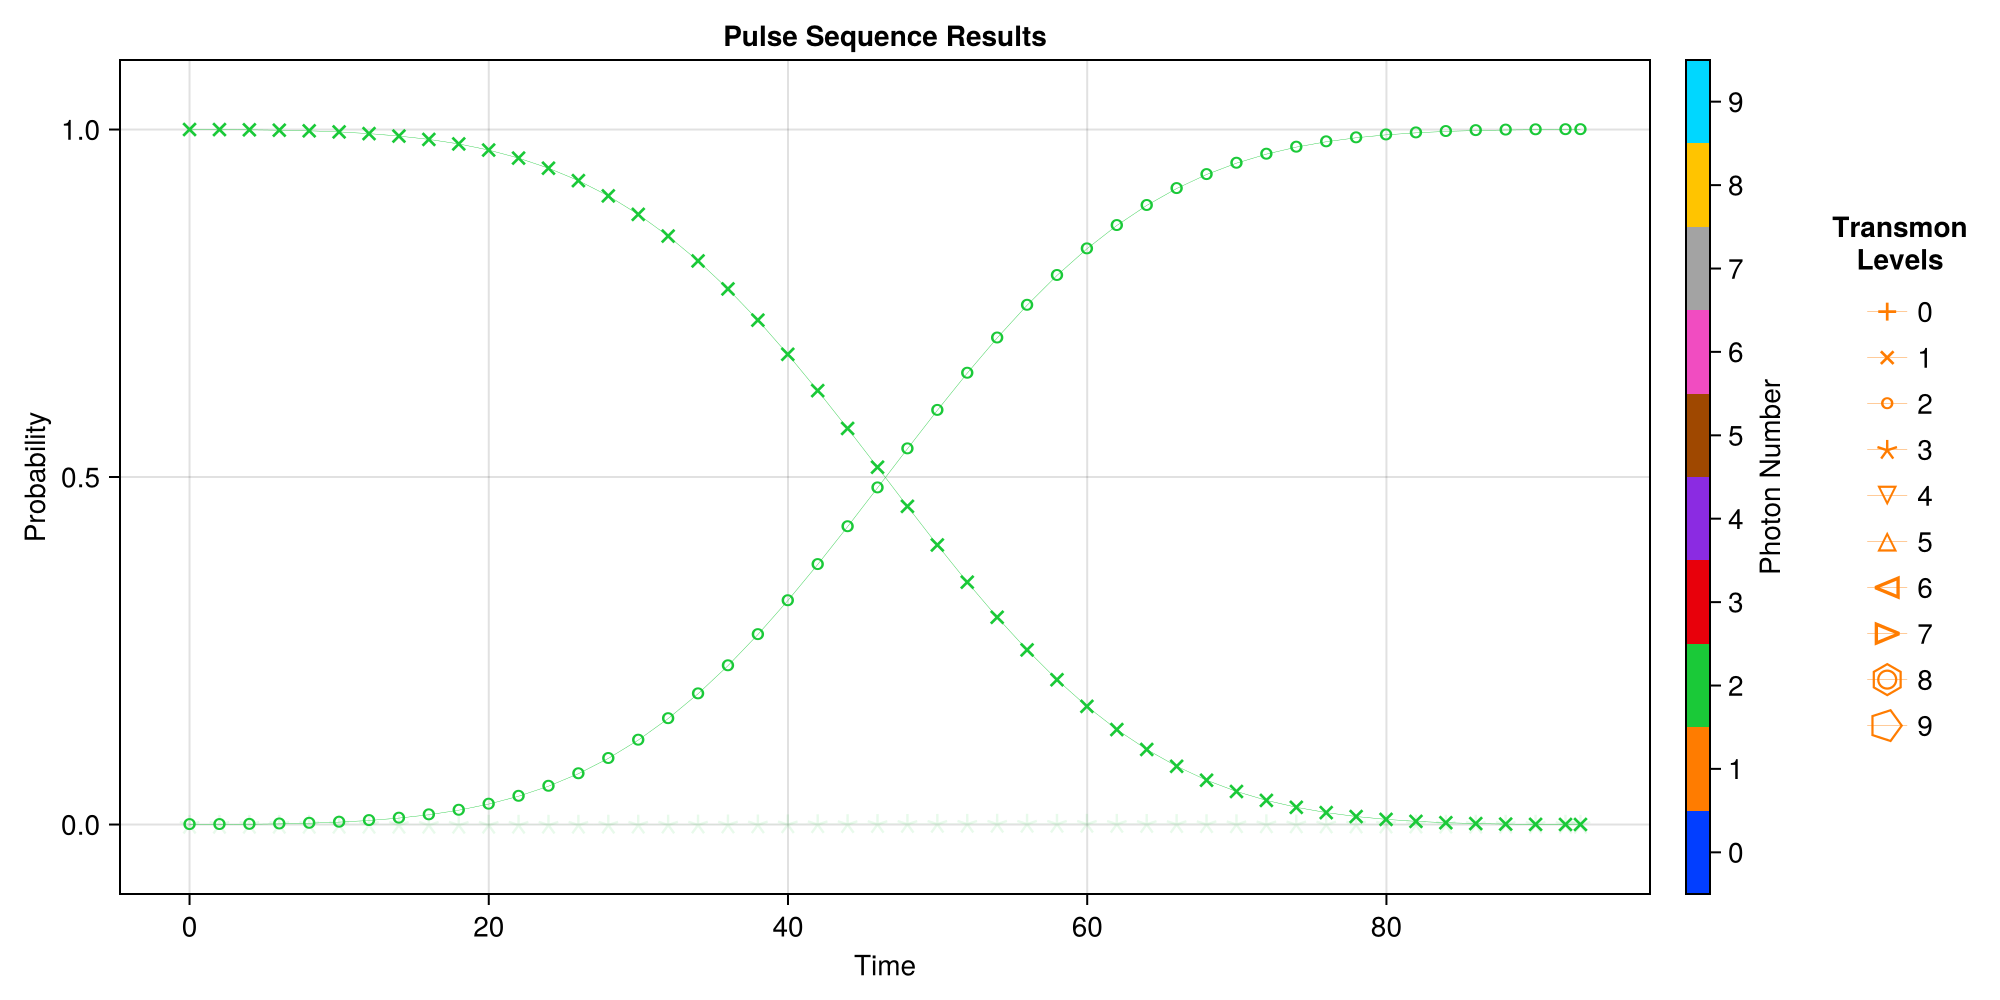

CairoMakie.Screen{IMAGE}


In [81]:
SC.Dynamics.PlotSingleModeEvolution(Mode7, q_ef2_res["times"], EVs, plot_every = 10, emph_states = [(1,2),(2,2)])

In [82]:
EVs[(2,2)][end]

0.9998945589642918 + 2.2539915078350678e-17im

In [83]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999999959610834 + 2.2843688074267964e-17im

##### $|1,3\rangle \to |2,3\rangle$

In [84]:
state1 = (1,3)
state2 = (2,3)
ψ1 = Mode7.dressed_states[state1]
ψ2 = Mode7.dressed_states[state2]

freq_d = Mode7.dressed_energies[state2]-Mode7.dressed_energies[state1]+ef_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 110]

qubit_ef3_opt_res = SC.Dynamics.OptimizePulse(Mode7, ψ1, ψ2, ef_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-10 20:10:50] Info: On Level 1
[2024-11-10 20:10:50] Info: On Step 1: t = 90.0
[2024-11-10 20:10:50] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-11-10 20:10:55] Info: Time Evolution Complete
[2024-11-10 20:10:55] Info: Done with Level_1_step_1
[2024-11-10 20:10:55] Info: Accurace: 0.9973658545074817
[2024-11-10 20:10:55] Info: ------------------------------------------------------------------------------
[2024-11-10 20:10:55] Info: On Step 2: t = 95.0
[2024-11-10 20:10:55] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-11-10 20:10:59] Info: Time Evolution Complete
[2024-11-10 20:10:59] Info: Done with Level_1_step_2
[2024-11-10 20:10:59] Info: Accurace: 0.9987258798664124
[2024-11-10 20:10:59] Info: ------------------------------------------------------------------------------
[2024-11-10 20:10:59] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 93.125
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2812, "mu"=>46.5625)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999888
  "freq_d"        => 4.49499

In [85]:
#Mode7.Stuff["op_drive_params"]["q_ef_3"] = deepcopy(qubit_ef3_opt_res)
if GLOBAL_SAVE_CALIBRATE | false
    Mode7.Stuff["op_drive_params"]["q_ef_3"] = deepcopy(qubit_ef3_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 93.125
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2812, "mu"=>46.5625)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999888
  "freq_d"        => 4.49499

In [86]:
ψ = Mode7.dressed_states[(1,3)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ef3_res = SC.Dynamics.RunPulseSequence(Mode7, ψ, ["q_ef_3"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-10T20:12:30.985
It is being saved at: Data/
[2024-11-10 20:12:30] Info: Running operator q_ef_3
[2024-11-10 20:12:30] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-10 20:12:34] Info: Time Evolution Complete
[2024-11-10 20:12:34] Info: Saving Steps
[2024-11-10 20:12:35] Info: Done with Step_1
[2024-11-10 20:12:35] Info: Done With Running Sequence
[2024-11-10 20:12:35] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199839, 0.399678, 0.599517, 0.799356, 0.999195, 1.1990…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [87]:
EVs = SC.Utils.Get_EVs(q_ef3_res["states"], proj_dict);

[2024-11-10 20:12:36] Info: Making Plot


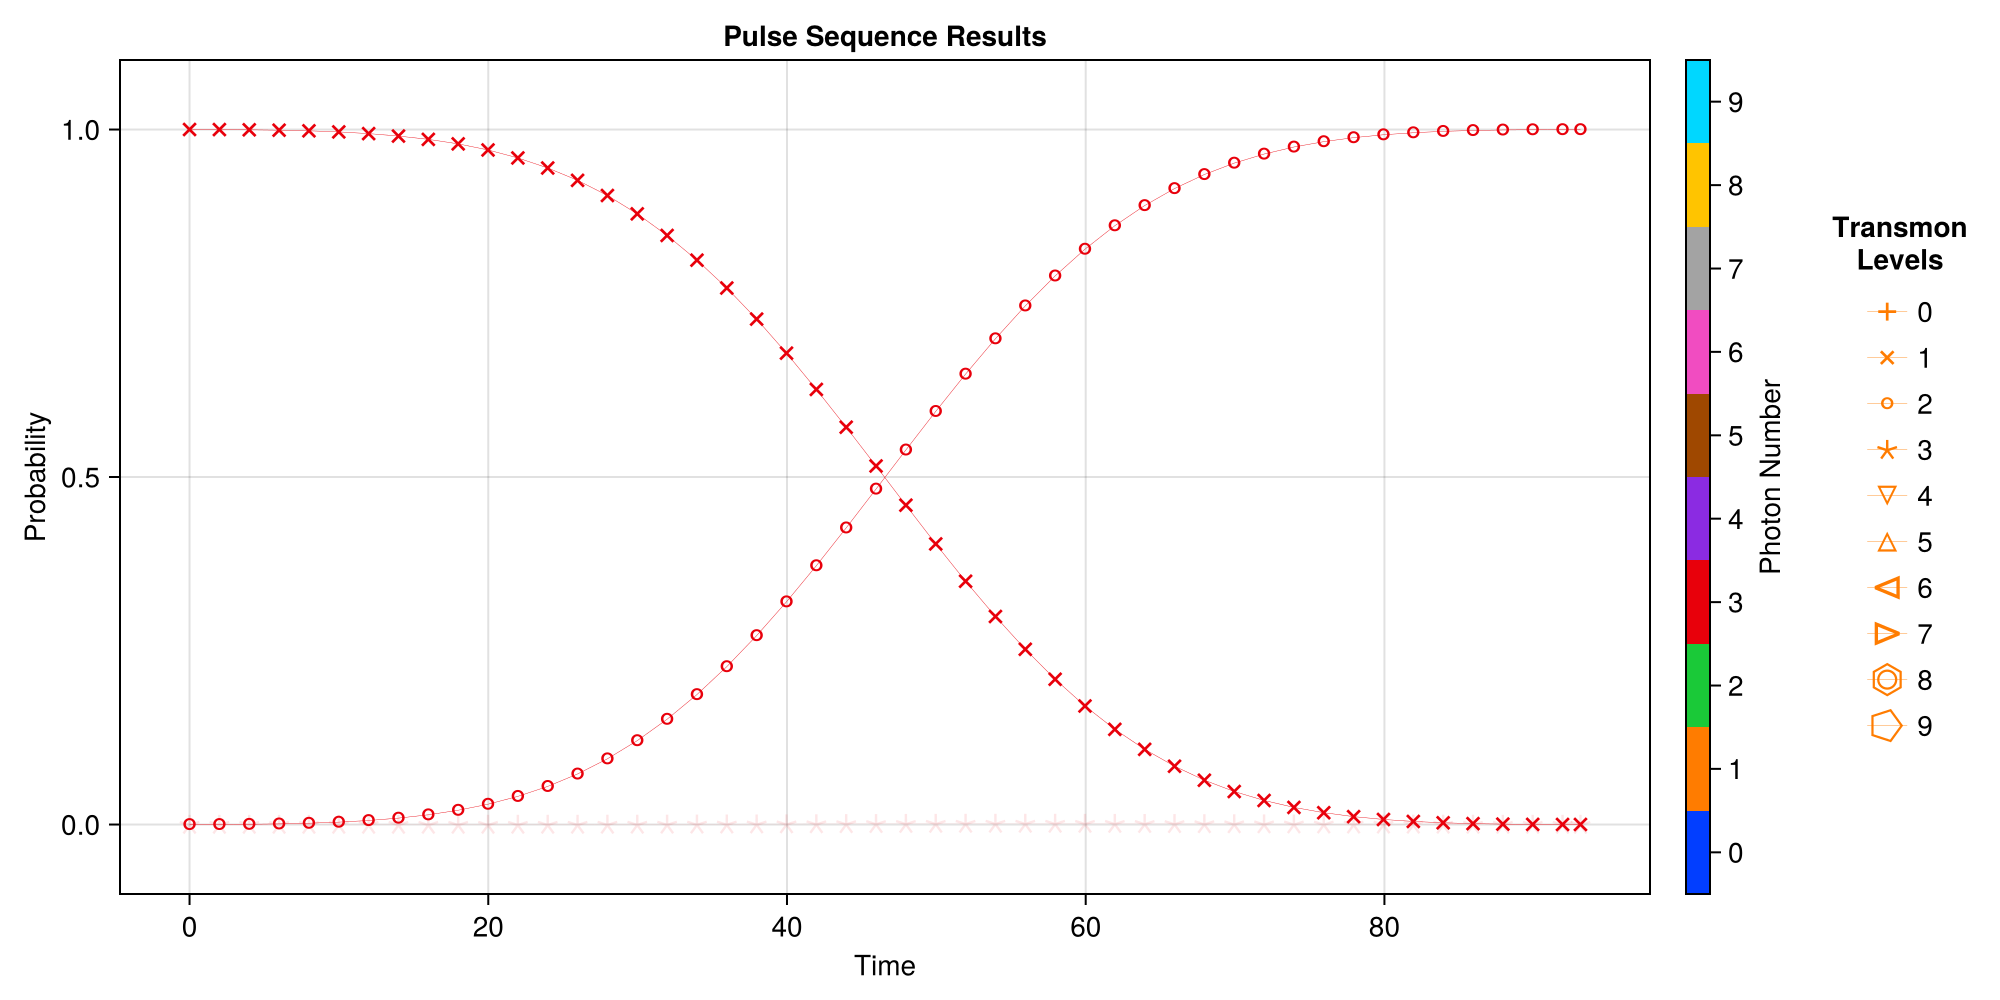

CairoMakie.Screen{IMAGE}


In [88]:
SC.Dynamics.PlotSingleModeEvolution(Mode7, q_ef3_res["times"], EVs, plot_every = 10, emph_states = [(1,3),(2,3)])

In [89]:
EVs[(2, 3)][end]

0.9998882560237206 + 7.19090916565392e-17im

In [90]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
tot

0.9999999999677738 + 7.14336455542256e-17im

### Half Qubit $|g0\rangle \to |g0\rangle+|e0\rangle$

In [91]:
starting_args = deepcopy(Mode7.Stuff["op_drive_params"]["q_ge_0"])

envelope_args = starting_args["Envelope Args"]
envelope = starting_args["Envelope"]
freq_d = starting_args["freq_d"]
stark_shift = starting_args["shift"]
ε = starting_args["epsilon"]*0.5

ψ1 = Mode7.dressed_states[(0,0)]
ψ2 = Mode7.dressed_states[(0,0)] + Mode7.dressed_states[(1,0)]
ψ2 = ψ2/sqrt(2)

op = Mode7.dressed_states[(0,0)]*Mode7.dressed_states[(1,0)]'*2



t_range = [starting_args["pulse_time"], starting_args["pulse_time"]]


optimize_res_half_g0e0 = SC.Dynamics.OptimizePulse(Mode7, ψ1, ψ2, ε, freq_d, stark_shift, t_range, envelope, envelope_args, levels = 1, samples_per_level = 1, check_op = op)

[2024-11-10 20:12:37] Info: On Level 1
[2024-11-10 20:12:37] Info: On Step 1: t = 92.96875
[2024-11-10 20:12:37] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-11-10 20:12:41] Info: Time Evolution Complete
[2024-11-10 20:12:41] Info: Done with Level_1_step_1
[2024-11-10 20:12:41] Info: Using Check Op
[2024-11-10 20:12:41] Info: Accurace: 0.9997766604015423
[2024-11-10 20:12:41] Info: ------------------------------------------------------------------------------
[2024-11-10 20:12:41] Info: Highest Accuracy: 0.9997766604015423
[2024-11-10 20:12:41] Info: New ti: 92.96875, new tf: 92.96875
[2024-11-10 20:12:41] Info: ===================================================================================================	


Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00269
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999777
  "freq_d"        => 4.6039

In [92]:
#Mode7.Stuff["op_drive_params"]["q_half_ge0"] = deepcopy(optimize_res_half_g0e0)
if GLOBAL_SAVE_CALIBRATE | false
    Mode7.Stuff["op_drive_params"]["q_half_ge0"] = deepcopy(optimize_res_half_g0e0)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00269
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999777
  "freq_d"        => 4.6039

In [93]:
ψ = Mode7.dressed_states[(0,0)]
res_half_ge0 = SC.Dynamics.RunPulseSequence(Mode7, ψ, ["q_half_ge0"], Return = true, clean_up = true)

The Name for this run is: Operator_Sequence_2024-11-10T20:12:41.997
It is being saved at: Data/
[2024-11-10 20:12:41] Info: Running operator q_half_ge0
[2024-11-10 20:12:41] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-10 20:12:45] Info: Time Evolution Complete
[2024-11-10 20:12:45] Info: Saving Steps
[2024-11-10 20:12:46] Info: Done with Step_1
[2024-11-10 20:12:46] Info: Done With Running Sequence
[2024-11-10 20:12:46] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [94]:
EVs_Dict = SC.Utils.Get_EVs(res_half_ge0["states"], proj_dict);

[2024-11-10 20:12:47] Info: Making Plot


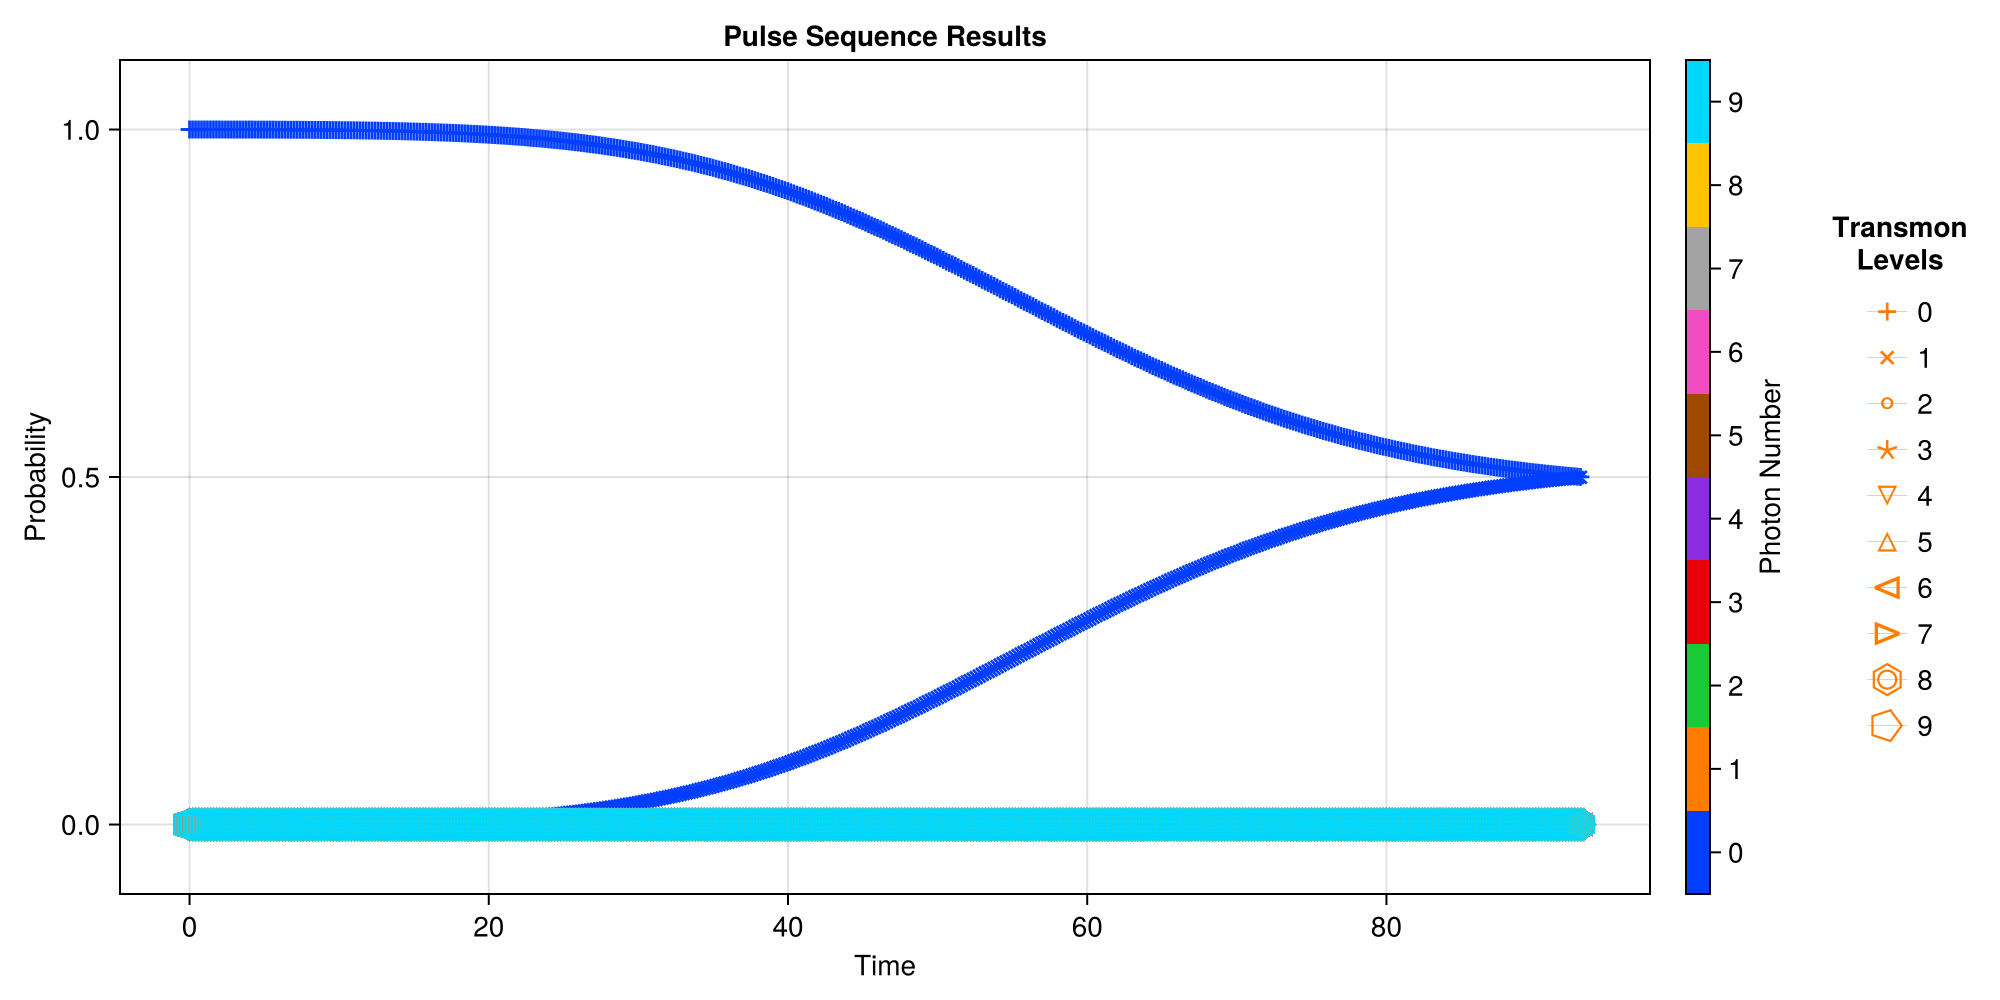

In [95]:
SC.Dynamics.PlotSingleModeEvolution(Mode7, res_half_ge0["times"], EVs_Dict);

In [96]:
println(EVs_Dict[(0,0)][end])
println(EVs_Dict[(1,0)][end])

0.5001087917583691 - 2.088237127640323e-17im
0.4996679658286239 - 1.735376339258297e-17im


In [97]:
SC.Utils.save_model(Mode7)

## Sidebands at $\varepsilon = 1.22$

### Getting Stark Shift

[2024-11-10 20:52:58] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


[2024-11-10 20:53:11] Info: Done With Floquet Sweep
[2024-11-10 20:53:11] Info: Fit Stuff: 3-element Vector{Float64}:	 0.023042463977587878	 0.0017369835275141902	 2.069849539663986
Stark shift res: [0.023042463977587878, 278.1413274349962]


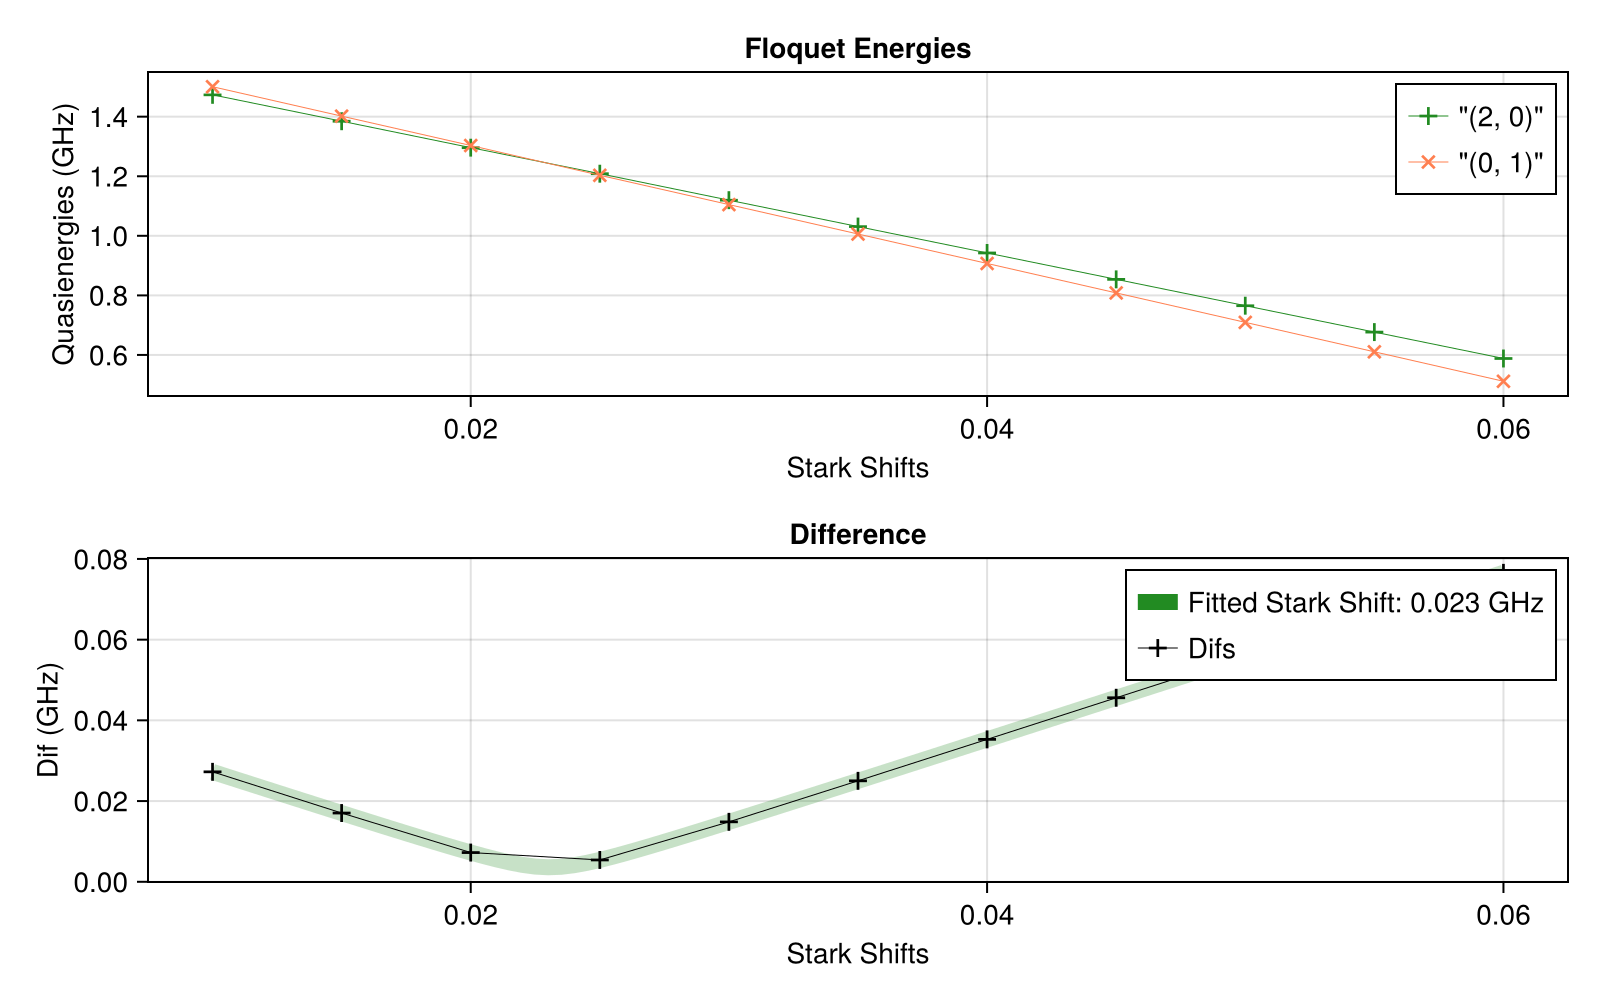

In [132]:
fngnp1_ε = 1.22
drive_op = Mode7.n̂ₜ
state1 = (2,0)
state2 = (0,1)

stark_shift_list = collect(LinRange(0.01, 0.06, 11))

stark_shift_res = SC.Dynamics.FindStarkShift(Mode7, state1, state2, fngnp1_ε, stark_shift_list)

println("Stark shift res: "*string(stark_shift_res))
fngnp1_stark_shift = stark_shift_res[1];
fngnp1_start_time = stark_shift_res[2];

In [133]:
fngnp1_ramp_time = 11.6257;

### f0->g1


In [5]:
println("Target flattop time: "*string(device_config["device"]["soc"]["sideband"]["pulses"]["fngnp1pi_times"][7][1]*1000))

Target flattop time: 267.7


In [135]:
ψ1 = Mode7.dressed_states[(2,0)]
ψ2 = Mode7.dressed_states[(0,1)]

freq_d = Mode7.dressed_energies[(0,1)]-Mode7.dressed_energies[(2,0)]

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>fngnp1_ramp_time, "k" => 2, "pulse_time" => 0)

t_range = [fngnp1_start_time, fngnp1_start_time+fngnp1_ramp_time*2]

optimize_res_f0g1 = SC.Dynamics.OptimizePulse(Mode7, ψ1, ψ2, fngnp1_ε, freq_d, fngnp1_stark_shift, t_range, envelope, envelope_args)

[2024-11-10 20:53:11] Info: On Level 1
[2024-11-10 20:53:11] Info: On Step 1: t = 278.1413274349962
[2024-11-10 20:53:11] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 05s (ETA: 0h 00m 00s)
[2024-11-10 20:53:16] Info: Time Evolution Complete
[2024-11-10 20:53:16] Info: Done with Level_1_step_1
[2024-11-10 20:53:16] Info: Accurace: 0.9944883565816492
[2024-11-10 20:53:16] Info: ------------------------------------------------------------------------------
[2024-11-10 20:53:16] Info: On Step 2: t = 283.9541774349962
[2024-11-10 20:53:16] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 06s (ETA: 0h 00m 00s)
[2024-11-10 20:53:23] Info: Time Evolution Complete
[2024-11-10 20:53:23] Info: Done with Level_1_step_2
[2024-11-10 20:53:23] Info: Accurace: 0.9982376488220889
[2024-11-10 20:53:23] Info: ------------------------------------------------------------------------------
[2024

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 291.22
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>291.22, "k"=>2, "ramp_time"=>…
  "epsilon"       => 1.22
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0230425
  "accuracy"      => 0.99993
  "freq_d"        => -1.88161

In [136]:
optimize_res_f0g1["pulse_time"]-optimize_res_f0g1["Envelope Args"]["ramp_time"]*2

267.9688399349962

In [137]:
#Mode7.Stuff["op_drive_params"]["sb_f0g1"] = deepcopy(optimize_res_f0g1_eps78)
if GLOBAL_SAVE_CALIBRATE | false
    Mode7.Stuff["op_drive_params"]["sb_f0g1"] = deepcopy(optimize_res_f0g1)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 291.22
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>291.22, "k"=>2, "ramp_time"=>…
  "epsilon"       => 1.22
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0230425
  "accuracy"      => 0.99993
  "freq_d"        => -1.88161

In [138]:
ψ = Mode7.dressed_states[(2,0)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
sb_f0g1_res = SC.Dynamics.RunPulseSequence(Mode7, ψ, ["sb_f0g1"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-10T20:59:05.260
It is being saved at: Data/
[2024-11-10 20:59:05] Info: Running operator sb_f0g1
[2024-11-10 20:59:05] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 06s (ETA: 0h 00m 00s)
[2024-11-10 20:59:12] Info: Time Evolution Complete
[2024-11-10 20:59:12] Info: Saving Steps
[2024-11-10 20:59:12] Info: Done with Step_1
[2024-11-10 20:59:12] Info: Done With Running Sequence
[2024-11-10 20:59:12] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199877, 0.399753, 0.59963, 0.799506, 0.999383, 1.19926…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [139]:
EVs_f0g1 = SC.Utils.Get_EVs(sb_f0g1_res["states"], proj_dict);

[2024-11-10 20:59:13] Info: Making Plot


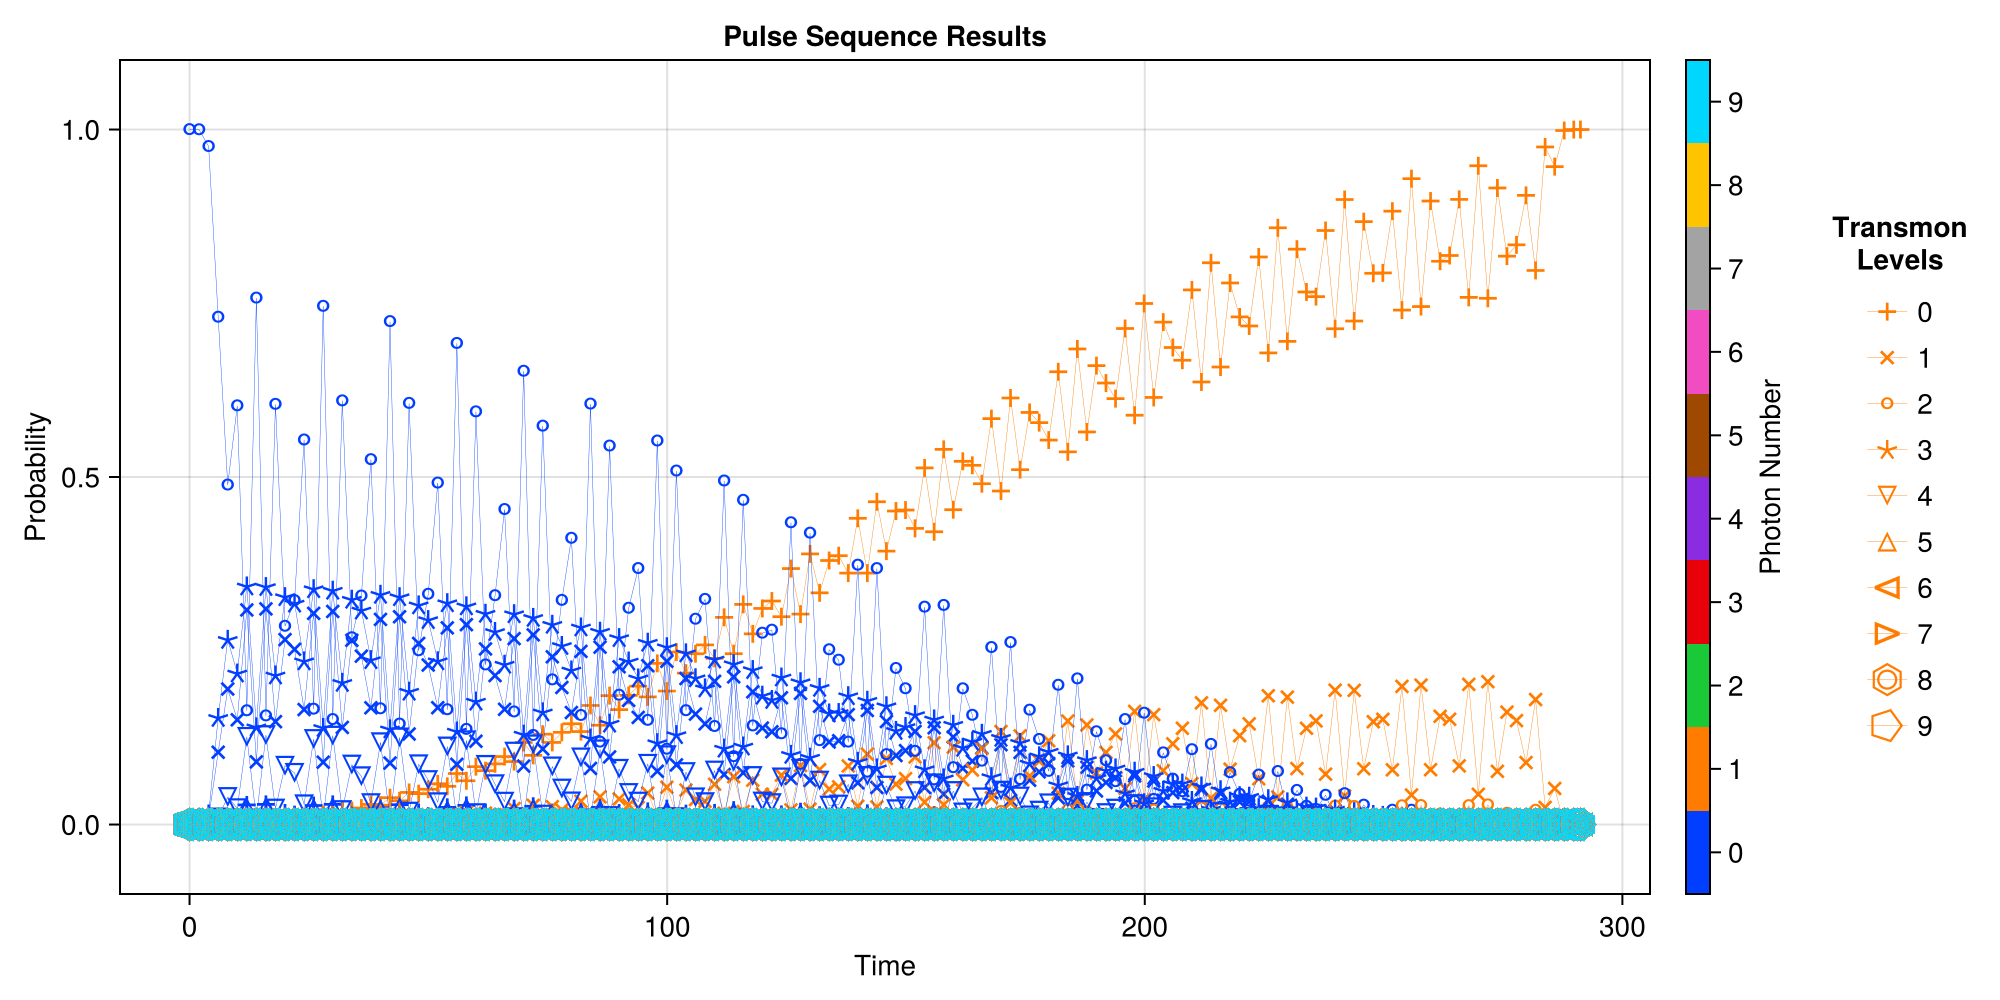

CairoMakie.Screen{IMAGE}


In [140]:
SC.Dynamics.PlotSingleModeEvolution(Mode7, sb_f0g1_res["times"], EVs_f0g1, plot_every = 10)

### f1->g2


In [6]:
println("Target flattop time: "*string(device_config["device"]["soc"]["sideband"]["pulses"]["fngnp1pi_times"][7][2]*1000))

Target flattop time: 193.7204799113105


In [142]:
ψ1 = Mode7.dressed_states[(2,1)]
ψ2 = Mode7.dressed_states[(0,2)]

freq_d = Mode7.dressed_energies[(0,2)]-Mode7.dressed_energies[(2,1)]

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>fngnp1_ramp_time, "k" => 2, "pulse_time" => 0)


t_range = [fngnp1_start_time/sqrt(2), fngnp1_start_time/sqrt(2)+fngnp1_ramp_time*2]


optimize_res_f1g2 = SC.Dynamics.OptimizePulse(Mode7, ψ1, ψ2, fngnp1_ε, freq_d, fngnp1_stark_shift, t_range, envelope, envelope_args)

[2024-11-10 20:59:14] Info: On Level 1
[2024-11-10 20:59:14] Info: On Step 1: t = 196.6756187575137
[2024-11-10 20:59:14] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-11-10 20:59:18] Info: Time Evolution Complete
[2024-11-10 20:59:18] Info: Done with Level_1_step_1
[2024-11-10 20:59:18] Info: Accurace: 0.9893683397256056
[2024-11-10 20:59:18] Info: ------------------------------------------------------------------------------
[2024-11-10 20:59:18] Info: On Step 2: t = 202.4884687575137
[2024-11-10 20:59:18] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-11-10 20:59:23] Info: Time Evolution Complete
[2024-11-10 20:59:23] Info: Done with Level_1_step_2
[2024-11-10 20:59:23] Info: Accurace: 0.996613131841145
[2024-11-10 20:59:23] Info: ------------------------------------------------------------------------------
[2024-

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 209.391
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>209.391, "k"=>2, "ramp_time"=…
  "epsilon"       => 1.22
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0230425
  "accuracy"      => 0.999704
  "freq_d"        => -1.88132

In [143]:
optimize_res_f1g2["pulse_time"]-optimize_res_f1g2["Envelope Args"]["ramp_time"]*2

186.13982813251374

In [144]:
#Mode7.Stuff["op_drive_params"]["sb_f1g2"] = deepcopy(optimize_res_f1g2_eps78)
if GLOBAL_SAVE_CALIBRATE | false
    Mode7.Stuff["op_drive_params"]["sb_f1g2"] = deepcopy(optimize_res_f1g2)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 209.391
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>209.391, "k"=>2, "ramp_time"=…
  "epsilon"       => 1.22
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0230425
  "accuracy"      => 0.999704
  "freq_d"        => -1.88132

### f2->g3

In [ ]:
println("Target flattop time: "*string(device_config["device"]["soc"]["sideband"]["pulses"]["fngnp1pi_times"][7][3]*1000))

Base.Meta.ParseError: ParseError:
# Error @ /local/gr400/Git Repositories/CavityModeDriveSimulations/UsingJuliaBase/MultimodeCalibrations/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y246sdnNjb2RlLXJlbW90ZQ==.jl:1:120
println("Target flattop time: "*string(device_config["device"]["soc"]["sideband"]["pulses"]["fngnp1pi_times"[7][3]*1000))
#                                                                                                                      └ ── Expected `]`

In [146]:
ψ1 = Mode7.dressed_states[(2,2)]
ψ2 = Mode7.dressed_states[(0,3)]

freq_d = Mode7.dressed_energies[(0,3)]-Mode7.dressed_energies[(2,2)]

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>fngnp1_ramp_time, "k" => 2, "pulse_time" => 0)

t_range = [fngnp1_start_time/sqrt(3), fngnp1_start_time/sqrt(3)+fngnp1_ramp_time*2]

optimize_res_f2g3 = SC.Dynamics.OptimizePulse(Mode7, ψ1, ψ2, fngnp1_ε, freq_d, fngnp1_stark_shift, t_range, envelope, envelope_args)

[2024-11-10 21:01:12] Info: On Level 1
[2024-11-10 21:01:12] Info: On Step 1: t = 160.5849702673549
[2024-11-10 21:01:12] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-10 21:01:16] Info: Time Evolution Complete
[2024-11-10 21:01:16] Info: Done with Level_1_step_1
[2024-11-10 21:01:16] Info: Accurace: 0.9843108207969232
[2024-11-10 21:01:16] Info: ------------------------------------------------------------------------------
[2024-11-10 21:01:16] Info: On Step 2: t = 166.3978202673549
[2024-11-10 21:01:16] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-10 21:01:20] Info: Time Evolution Complete
[2024-11-10 21:01:20] Info: Done with Level_1_step_2
[2024-11-10 21:01:20] Info: Accurace: 0.9949983603947393
[2024-11-10 21:01:20] Info: ------------------------------------------------------------------------------
[2024

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 173.301
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>173.301, "k"=>2, "ramp_time"=…
  "epsilon"       => 1.22
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0230425
  "accuracy"      => 0.99945
  "freq_d"        => -1.88102

In [147]:
optimize_res_f2g3["pulse_time"]-optimize_res_f2g3["Envelope Args"]["ramp_time"]*2

150.04917964235491

In [148]:
#Mode7.Stuff["op_drive_params"]["sb_f2g3"] = deepcopy(optimize_res_f2g3_eps78)
if GLOBAL_SAVE_CALIBRATE | false
    Mode7.Stuff["op_drive_params"]["sb_f2g3"] = deepcopy(optimize_res_f2g3)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 173.301
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>173.301, "k"=>2, "ramp_time"=…
  "epsilon"       => 1.22
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0230425
  "accuracy"      => 0.99945
  "freq_d"        => -1.88102

### f3->g4

In [ ]:
println("Target flattop time: "*string(device_config["device"]["soc"]["sideband"]["pulses"]["fngnp1pi_times"][7][4]*1000))

Base.Meta.ParseError: ParseError:
# Error @ /local/gr400/Git Repositories/CavityModeDriveSimulations/UsingJuliaBase/MultimodeCalibrations/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y254sdnNjb2RlLXJlbW90ZQ==.jl:1:120
println("Target flattop time: "*string(device_config["device"]["soc"]["sideband"]["pulses"]["fngnp1pi_times"[7][4]*1000))
#                                                                                                                      └ ── Expected `]`

In [150]:
ψ1 = Mode7.dressed_states[(2,3)]
ψ2 = Mode7.dressed_states[(0,4)]

freq_d = Mode7.dressed_energies[(0,4)]-Mode7.dressed_energies[(2,3)]

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>fngnp1_ramp_time, "k" => 2, "pulse_time" => 0)

t_range = [fngnp1_start_time/sqrt(4), fngnp1_start_time/sqrt(4)+fngnp1_ramp_time*2]

optimize_res_f3g4 = SC.Dynamics.OptimizePulse(Mode7, ψ1, ψ2, fngnp1_ε, freq_d, fngnp1_stark_shift, t_range, envelope, envelope_args)

[2024-11-10 21:02:55] Info: On Level 1
[2024-11-10 21:02:55] Info: On Step 1: t = 139.0706637174981
[2024-11-10 21:02:55] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-10 21:02:58] Info: Time Evolution Complete
[2024-11-10 21:02:58] Info: Done with Level_1_step_1
[2024-11-10 21:02:58] Info: Accurace: 0.9793003446130671
[2024-11-10 21:02:58] Info: ------------------------------------------------------------------------------
[2024-11-10 21:02:58] Info: On Step 2: t = 144.8835137174981
[2024-11-10 21:02:58] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-10 21:03:01] Info: Time Evolution Complete
[2024-11-10 21:03:01] Info: Done with Level_1_step_2
[2024-11-10 21:03:01] Info: Accurace: 0.9933972173776885
[2024-11-10 21:03:01] Info: ------------------------------------------------------------------------------
[2024

Excessive output truncated after 524374 bytes.

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 151.786
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>151.786, "k"=>2, "ramp_time"=…
  "epsilon"       => 1.22
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0230425
  "accuracy"      => 0.999187
  "freq_d"        => -1.88073

In [151]:
optimize_res_f3g4["pulse_time"]-optimize_res_f3g4["Envelope Args"]["ramp_time"]*2

128.5348730924981

In [152]:
#Mode7.Stuff["op_drive_params"]["sb_f3g4"] = deepcopy(optimize_res_f3g4_eps78)
if GLOBAL_SAVE_CALIBRATE | false
    Mode7.Stuff["op_drive_params"]["sb_f3g4"] = deepcopy(optimize_res_f3g4)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 151.786
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>151.786, "k"=>2, "ramp_time"=…
  "epsilon"       => 1.22
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0230425
  "accuracy"      => 0.999187
  "freq_d"        => -1.88073

In [153]:
SC.Utils.save_model(Mode7)

## Other Specific Gates

### Special Side Bands

#### f1_2pi_g3

##### Getting Drive Strength and Stark Shift

In [ ]:
n1 = 1
n2 = 3

freq1 = Mode7.dressed_energies[(2,n1)]-Mode7.dressed_energies[(0,n1+1)]
freq2 = Mode7.dressed_energies[(2,n2)]-Mode7.dressed_energies[(0,n2+1)]

χ = abs(freq1-freq2)
println("χ: $χ")

m = sqrt(2)^(abs(n2-n1)-1)
println("m: $m")

n = Int(floor(m/2)+1)
println("n: $n")

eps_f1_2pi_g3 = 1000*χ/(2*(4*n^2-m^2)^(1/2))*0.3
println("Required Epsilon: $eps_f1_2pi_g3")

χ: 0.0007848970006136824
m: 1.4142135623730951
n: 1
Required Epsilon: 0.0832508987500375


[2024-11-08 18:41:51] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:20


[2024-11-08 18:42:12] Info: Done With Floquet Sweep
[2024-11-08 18:42:12] Info: Fit Stuff: 3-element Vector{Float64}:	 0.0007613188025463708	 0.0005267568261410399	 2.0028257671502483


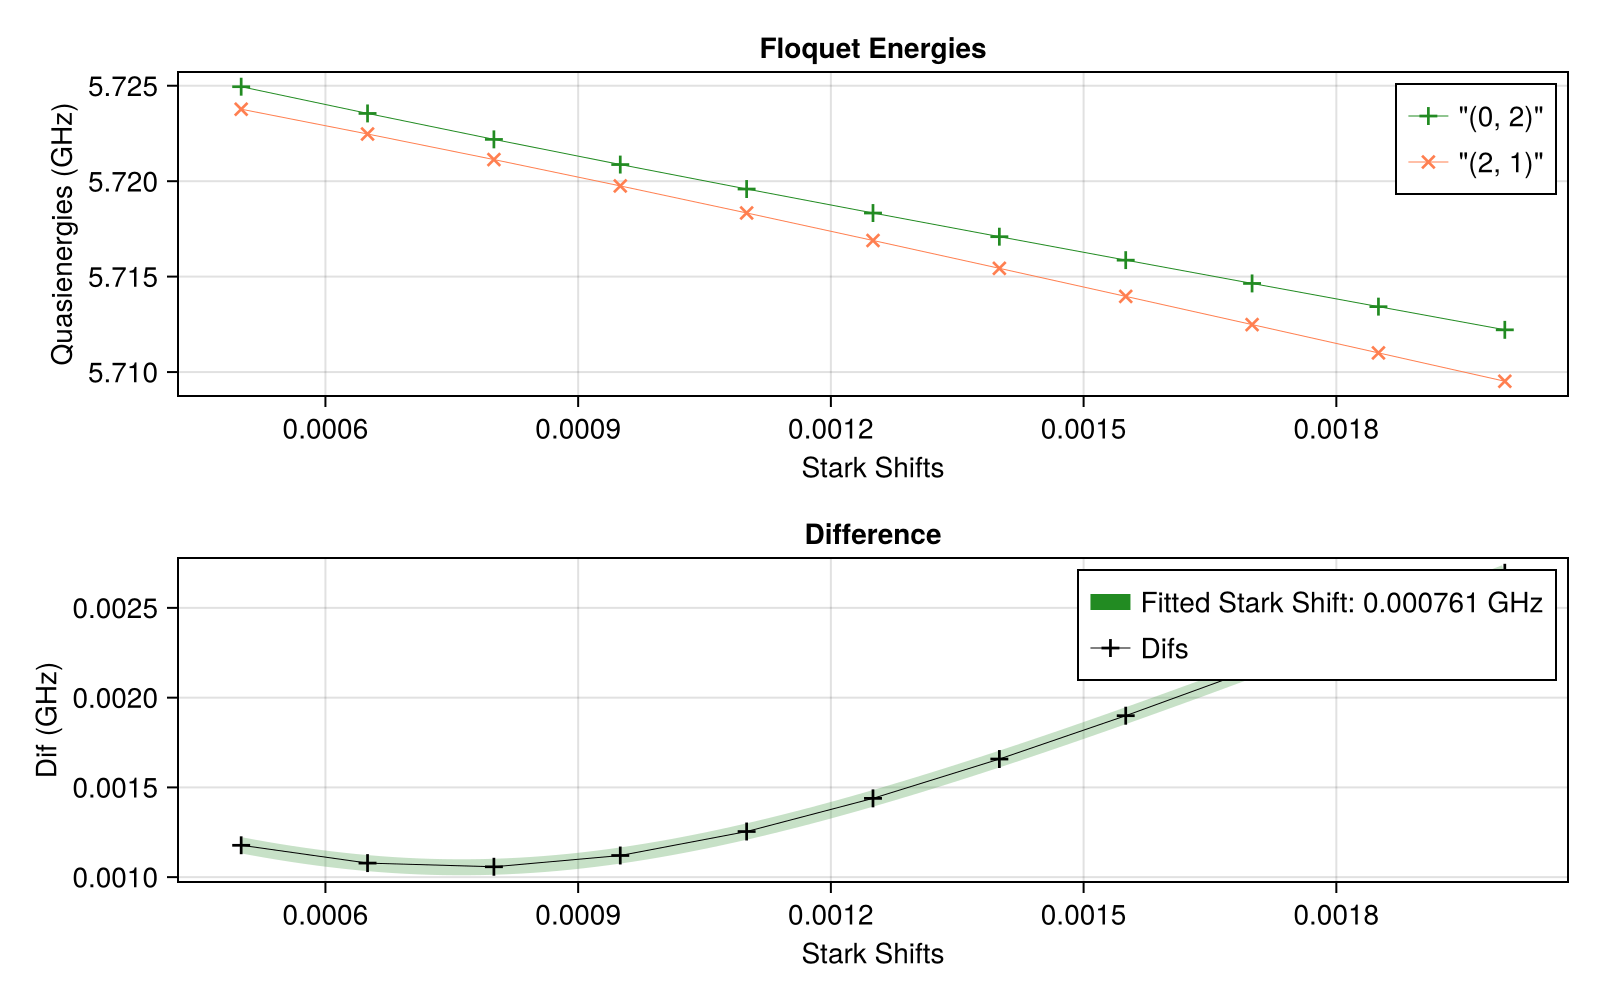

2-element Vector{Float64}:
   0.0007613188025463708
 947.8653719249797

In [ ]:
ε = eps_f1_2pi_g3
drive_op = Mode7.n̂ₜ
state1 = (2,n1)
state2 = (0,n1+1)

#stark_shift_list = collect(LinRange(0.0005, 0.002, 11))
stark_shift_list = collect(LinRange(0.0005, 0.002, 11))

stark_shift_res_f0_2pi_g3 = SC.Dynamics.FindStarkShift(Mode7, state1, state2, ε, stark_shift_list)

##### Optimizing Pulse

In [17]:
n2

3

In [ ]:
ψ1 = Mode7.dressed_states[(2,n1)]+Mode7.dressed_states[(2,n2)]
ψ1 = ψ1/qt.norm(ψ1)
ψ2 = Mode7.dressed_states[(0,n1+1)]+Mode7.dressed_states[(2,n2)]
ψ2 = ψ2/qt.norm(ψ2)


freq_d = Mode7.dressed_energies[(0,n1+1)]-Mode7.dressed_energies[(2, n1)]

ramp_time = 11.6257

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>ramp_time, "k" => 2, "pulse_time" => 0)

check_op = Mode7.dressed_states[(0,n1+1)]*Mode7.dressed_states[(2,n2)]'*2

stark_shift = stark_shift_res_f0_2pi_g3[1]
initial_time = stark_shift_res_f0_2pi_g3[2]

t_range = [initial_time*0.99, initial_time*1.01]

optimize_res_f1g2_2pi_f3g4 = SC.Dynamics.OptimizePulse(Mode7, ψ1, ψ2, eps_f1_2pi_g3, freq_d, stark_shift, t_range, envelope, envelope_args, levels = 1, samples_per_level = 7, check_op = check_op);

[2024-11-08 18:42:12] Info: On Level 1
[2024-11-08 18:42:12] Info: On Step 1: t = 938.38671820573
[2024-11-08 18:42:12] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 42s (ETA: 0h 00m 00s)
[2024-11-08 18:42:55] Info: Time Evolution Complete
[2024-11-08 18:42:55] Info: Done with Level_1_step_1
[2024-11-08 18:42:55] Info: Using Check Op
[2024-11-08 18:42:55] Info: Accurace: 0.9993598958222756
[2024-11-08 18:42:55] Info: ------------------------------------------------------------------------------
[2024-11-08 18:42:55] Info: On Step 2: t = 941.5462694454799
[2024-11-08 18:42:55] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 43s (ETA: 0h 00m 00s)
[2024-11-08 18:43:39] Info: Time Evolution Complete
[2024-11-08 18:43:39] Info: Done with Level_1_step_2
[2024-11-08 18:43:39] Info: Using Check Op
[2024-11-08 18:43:39] Info: Accurace: 0.9994618631727932
[2024-11-08 18:43:39] Info: 

In [19]:
optimize_res_f1g2_2pi_f3g4["pulse_time"] - optimize_res_f1g2_2pi_f3g4["Envelope Args"]["ramp_time"]*2

921.4544206852298

In [ ]:
#Mode7.Stuff["op_drive_params"]["sb_f1g2_2pi_f3g4"] = deepcopy(optimize_res_f1g2_2pi_f3g4)
if GLOBAL_SAVE_CALIBRATE | false
    Mode7.Stuff["op_drive_params"]["sb_f1g2_2pi_f3g4"] = deepcopy(optimize_res_f1g2_2pi_f3g4)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 944.706
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>944.706, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.0832509
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.000761319
  "accuracy"      => 0.999482
  "freq_d"        => -3.10383

In [ ]:
ψ = Mode7.dressed_states[(2,1)]+Mode7.dressed_states[(2,3)]
ψ = ψ/sqrt(2)
res_f1g2_2pi_f3g4 = SC.Dynamics.RunPulseSequence(Mode7, ψ, ["sb_f1g2_2pi_f3g4"], Return = true, clean_up = true)

The Name for this run is: Operator_Sequence_2024-11-08T18:48:49.463
It is being saved at: Data/
[2024-11-08 18:48:49] Info: Running operator sb_f1g2_2pi_f3g4
[2024-11-08 18:48:49] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 41s (ETA: 0h 00m 00s)
[2024-11-08 18:49:30] Info: Time Evolution Complete
[2024-11-08 18:49:30] Info: Saving Steps
[2024-11-08 18:49:37] Info: Done with Step_1
[2024-11-08 18:49:37] Info: Done With Running Sequence
[2024-11-08 18:49:37] Info: Loading Data


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.19998, 0.39996, 0.59994, 0.79992, 0.9999, 1.19988, 1.3…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [22]:
EVs_Dict = SC.Utils.Get_EVs(res_f1g2_2pi_f3g4["states"], proj_dict);

[2024-11-08 18:49:42] Info: Making Plot


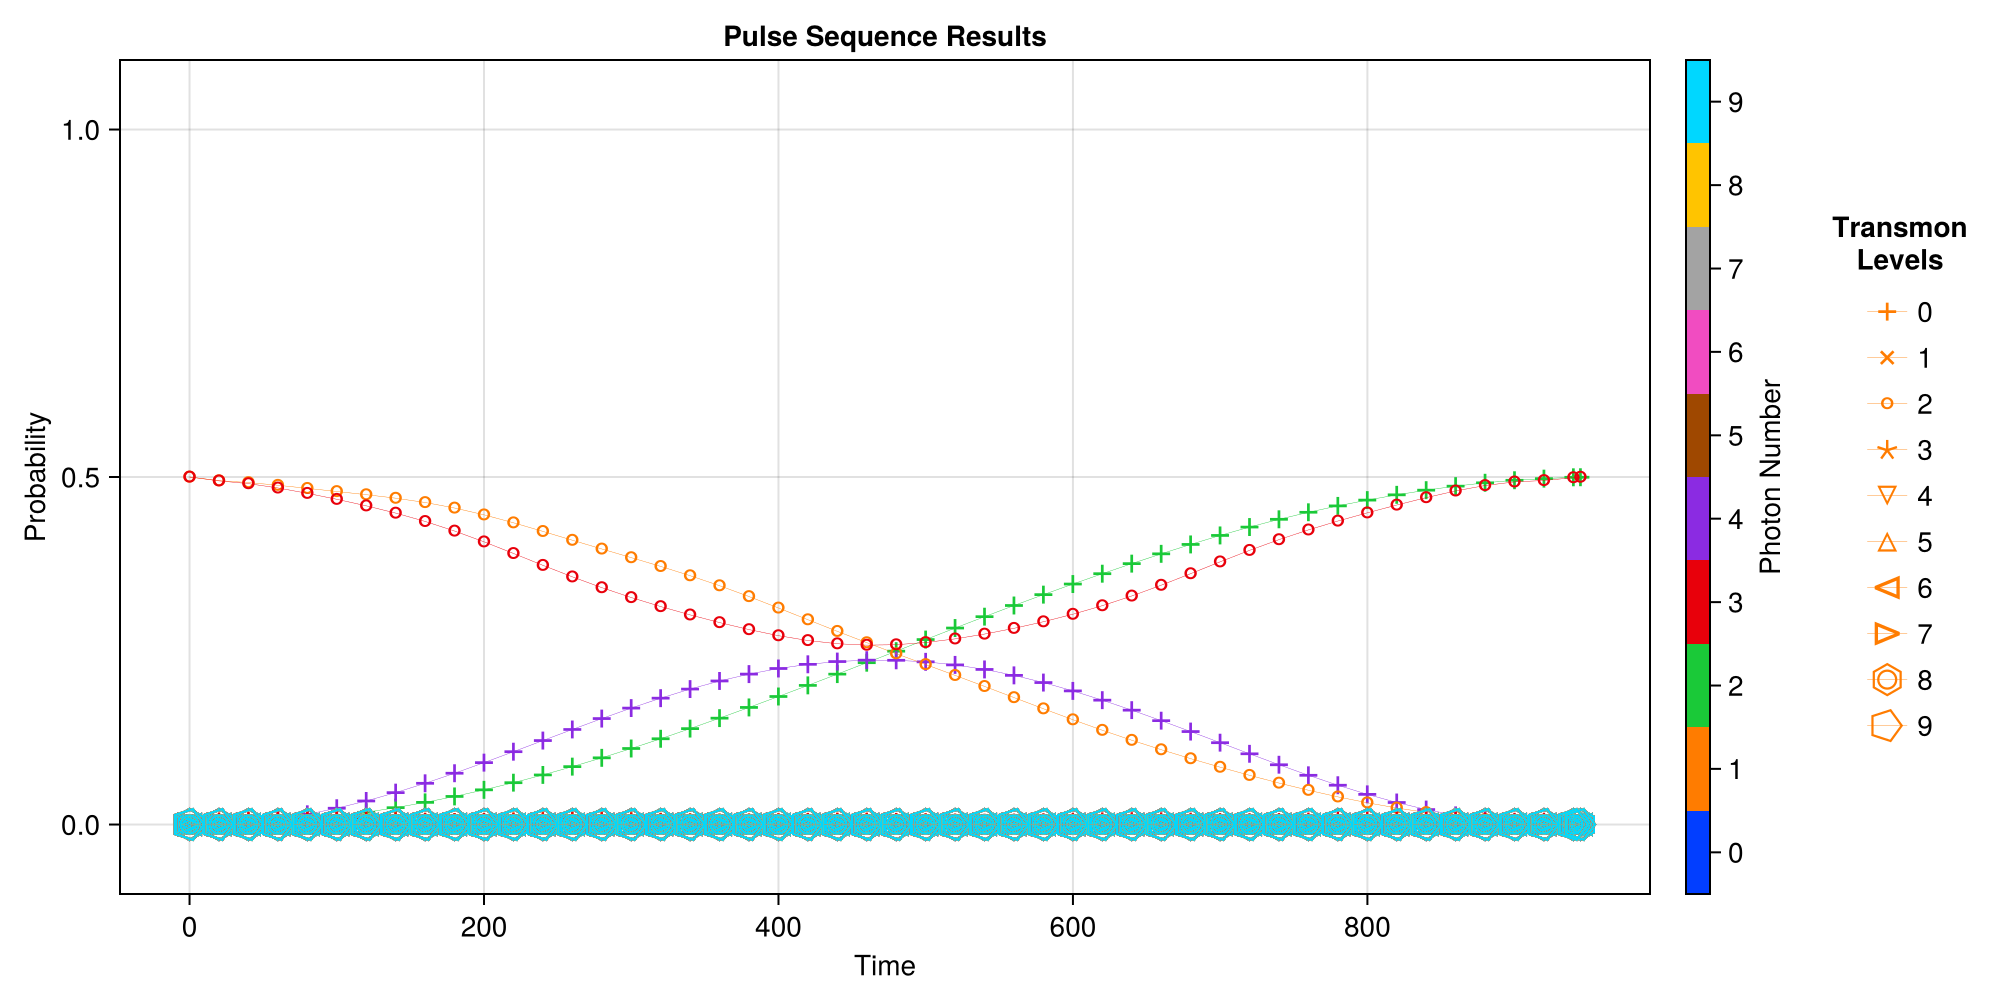

CairoMakie.Screen{IMAGE}


In [ ]:
SC.Dynamics.PlotSingleModeEvolution(Mode7, res_f1g2_2pi_f3g4["times"], EVs_Dict, plot_every = 100)

In [24]:
println(EVs_Dict[(2,3)][end])
println(EVs_Dict[(0,2)][end])

0.49979117254934646 + 4.706245818708166e-17im
0.4996905168282355 + 6.065084884910372e-17im


#### f0_4pi_g3

##### Getting Drive Strength and Stark Shift

In [ ]:
n1 = 0
n2 = 3

freq1 = Mode7.dressed_energies[(2,n1)]-Mode7.dressed_energies[(0,n1+1)]
freq2 = Mode7.dressed_energies[(2,n2)]-Mode7.dressed_energies[(0,n2+1)]

χ = abs(freq1-freq2)
println("χ: $χ")

m = sqrt(2)^(abs(n2-n1)-1)
println("m: $m")

n = Int(floor(m/2)+1)
println("n: $n")

eps_f0g1_4pi_f3g4 = 1000*χ/(2*(4*n^2-m^2)^(1/2))*0.45
println("Required Epsilon: $eps_f0g1_4pi_f3g4")

χ: 0.001177480925420582
m: 2.0000000000000004
n: 2
Required Epsilon: 0.07647962954143757


[2024-11-08 18:55:07] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


[2024-11-08 18:55:29] Info: Done With Floquet Sweep
[2024-11-08 18:55:29] Info: Fit Stuff: 3-element Vector{Float64}:	 0.0006433530530826274	 0.0003423902156711056	 2.002387126418146


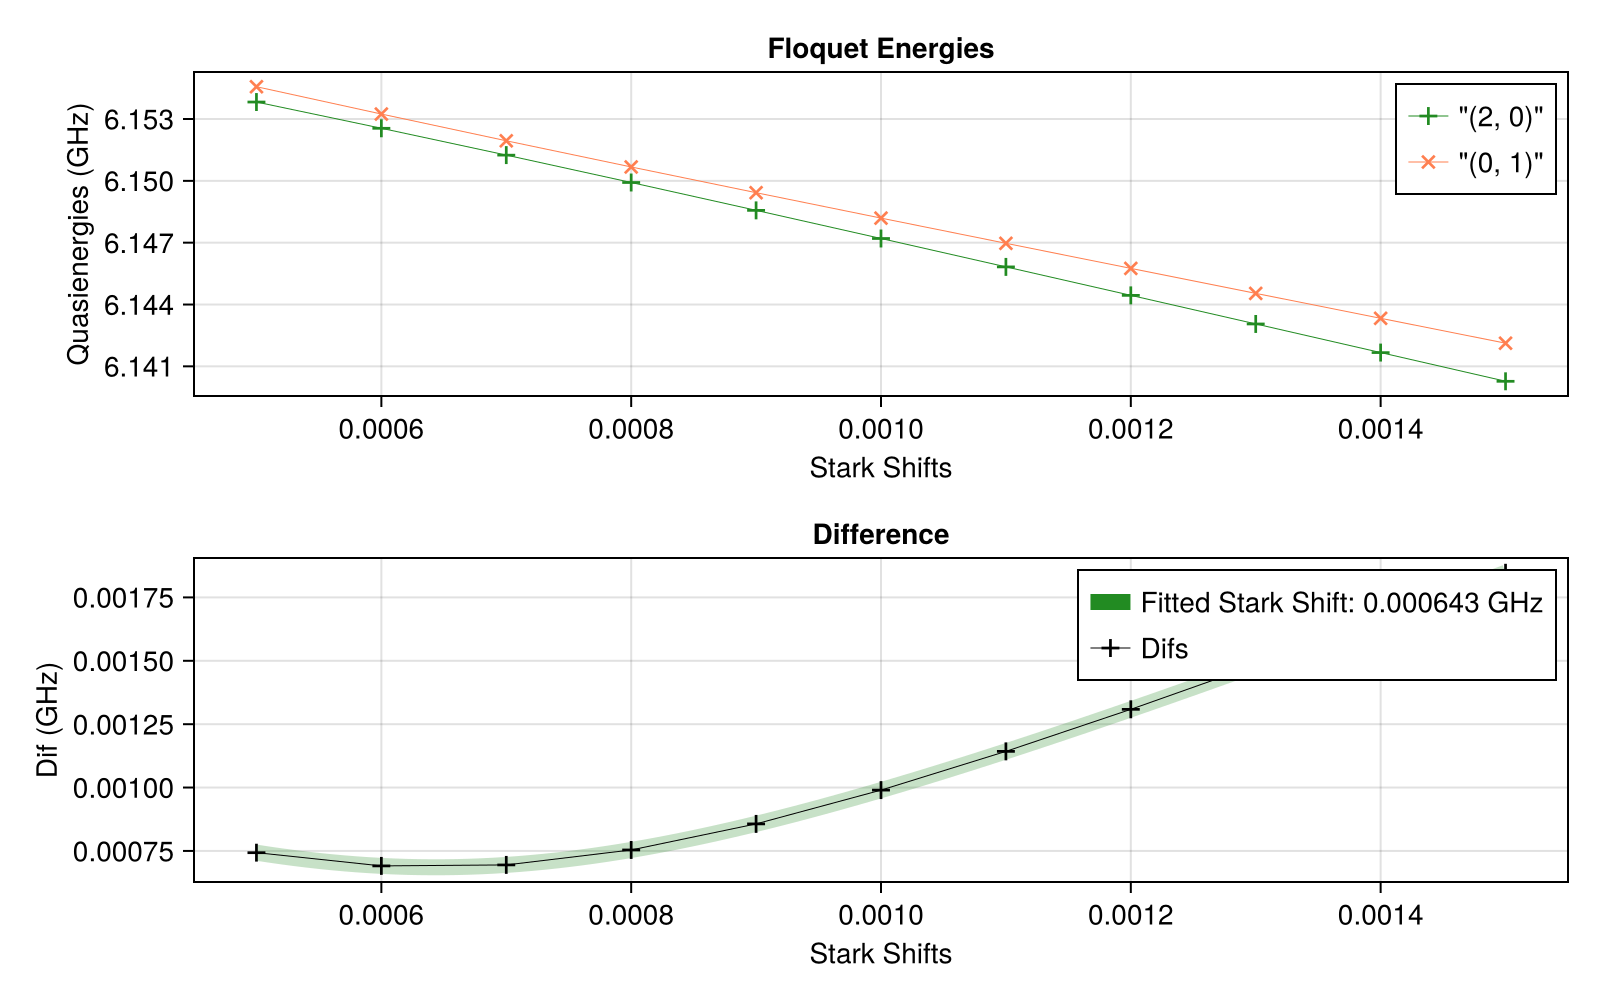

2-element Vector{Float64}:
    0.0006433530530826274
 1458.5811947459163

In [ ]:
ε = eps_f0g1_4pi_f3g4
drive_op = Mode7.n̂ₜ
state1 = (2,n1)
state2 = (0,n1+1)

stark_shift_list = collect(LinRange(0.0005, 0.0015, 11))

stark_shift_res_f0g1_4pi_f3g4 = SC.Dynamics.FindStarkShift(Mode7, state1, state2, ε, stark_shift_list)

##### Optimizing Pulse

In [ ]:
ψ1 = Mode7.dressed_states[(2,n1)]+Mode7.dressed_states[(2,n2)]
ψ1 = ψ1/qt.norm(ψ1)
ψ2 = Mode7.dressed_states[(0,n1+1)]+Mode7.dressed_states[(2,n2)]
ψ2 = ψ2/qt.norm(ψ2)

freq_d = Mode7.dressed_energies[(0,n1+1)]-Mode7.dressed_energies[(2, n1)]

check_op = 2*Mode7.dressed_states[(0,n1+1)]*Mode7.dressed_states[(2,n2)]'

ramp_time = 11.6257

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>ramp_time, "k" => 2, "pulse_time" => 0)

stark_shift = stark_shift_res_f0g1_4pi_f3g4[1]
initial_time = stark_shift_res_f0g1_4pi_f3g4[2]

ν = abs((stark_shift+freq_d))
t_range = [initial_time, initial_time+2*ramp_time]

optimize_res_f0g1_4pi_f3g4 = SC.Dynamics.OptimizePulse(Mode7, ψ1, ψ2, eps_f0g1_4pi_f3g4, freq_d, stark_shift, t_range, envelope, envelope_args, levels = 1, samples_per_level = 2, check_op = check_op)

[2024-11-08 18:55:29] Info: On Level 1
[2024-11-08 18:55:29] Info: On Step 1: t = 1458.5811947459163
[2024-11-08 18:55:29] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 01m 11s (ETA: 0h 00m 00s)
[2024-11-08 18:56:41] Info: Time Evolution Complete
[2024-11-08 18:56:41] Info: Done with Level_1_step_1
[2024-11-08 18:56:41] Info: Using Check Op
[2024-11-08 18:56:41] Info: Accurace: 0.9986803501131906
[2024-11-08 18:56:41] Info: ------------------------------------------------------------------------------
[2024-11-08 18:56:41] Info: On Step 2: t = 1481.8325947459164
[2024-11-08 18:56:41] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 01m 15s (ETA: 0h 00m 00s)
[2024-11-08 18:57:57] Info: Time Evolution Complete
[2024-11-08 18:57:57] Info: Done with Level_1_step_2
[2024-11-08 18:57:57] Info: Using Check Op
[2024-11-08 18:57:57] Info: Accurace: 0.999820378239168
[2024-11-08 18:57:57] Inf

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 1481.83
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>1481.83, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.0764796
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.000643353
  "accuracy"      => 0.99982
  "freq_d"        => -3.10422

In [ ]:
#Mode7.Stuff["op_drive_params"]["sb_f0g1_4pi_f3g4"] = deepcopy(optimize_res_f0g1_4pi_f3g4)
if GLOBAL_SAVE_CALIBRATE | false
    Mode7.Stuff["op_drive_params"]["sb_f0g1_4pi_f3g4"] = deepcopy(optimize_res_f0g1_4pi_f3g4)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 1481.83
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>1481.83, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.0764796
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.000643353
  "accuracy"      => 0.99982
  "freq_d"        => -3.10422

In [ ]:
ψ = Mode7.dressed_states[(2,0)]+Mode7.dressed_states[(2,3)]
ψ = ψ/sqrt(2)
res_f0g1_4pi_f3g4 = SC.Dynamics.RunPulseSequence(Mode7, ψ, ["sb_f0g1_4pi_f3g4"], Return = true, clean_up = true, spns = 1)

The Name for this run is: Operator_Sequence_2024-11-08T18:58:08.288
It is being saved at: Data/
[2024-11-08 18:58:08] Info: Running operator sb_f0g1_4pi_f3g4
[2024-11-08 18:58:08] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 01m 03s (ETA: 0h 00m 00s)
[2024-11-08 18:59:12] Info: Time Evolution Complete
[2024-11-08 18:59:12] Info: Saving Steps
[2024-11-08 18:59:12] Info: Done with Step_1
[2024-11-08 18:59:12] Info: Done With Running Sequence
[2024-11-08 18:59:12] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.999887, 1.99977, 2.99966, 3.99955, 4.99944, 5.99932, 6…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [35]:
EVs_Dict = SC.Utils.Get_EVs(res_f0g1_4pi_f3g4["states"], proj_dict);

[2024-11-08 18:59:13] Info: Making Plot


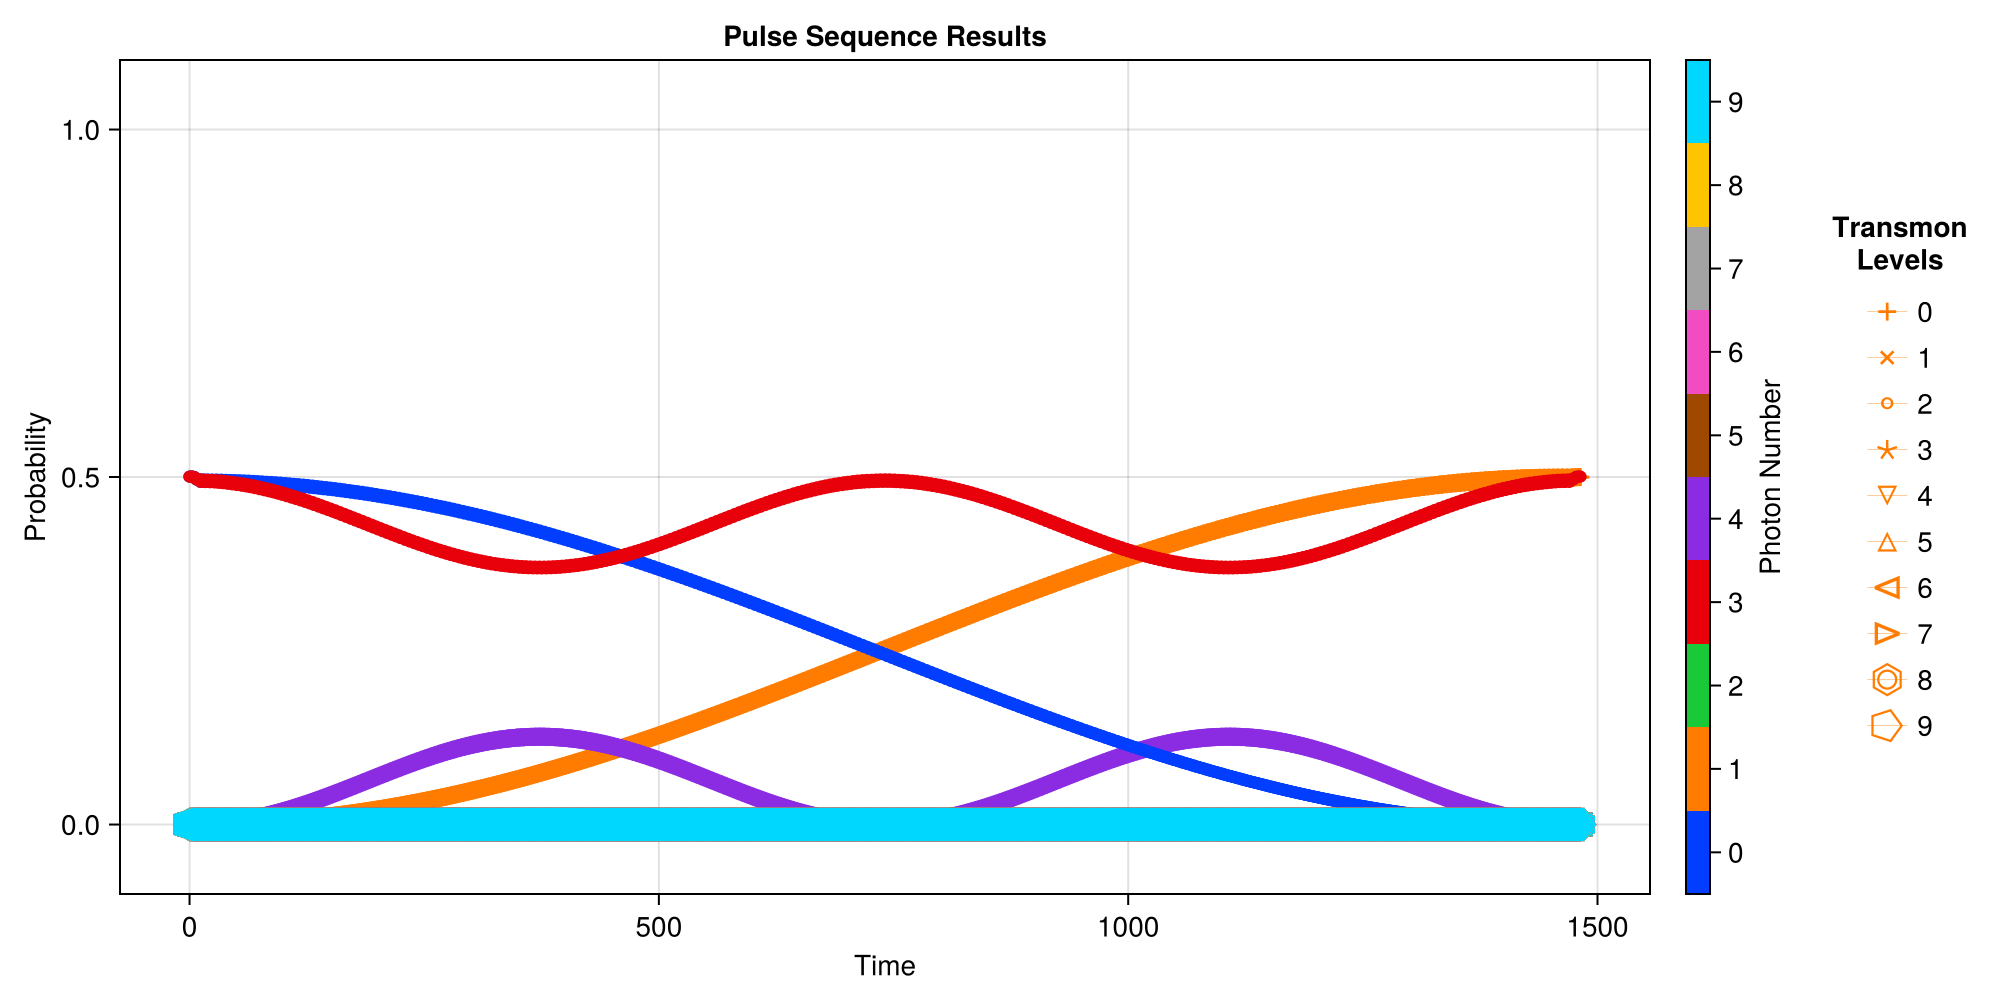

CairoMakie.Screen{IMAGE}


In [ ]:
SC.Dynamics.PlotSingleModeEvolution(Mode7, res_f0g1_4pi_f3g4["times"], EVs_Dict)

In [37]:
println(EVs_Dict[(2,3)][end])
println(EVs_Dict[(0,1)][end])

0.4999974818391036 + 3.209912380096676e-17im
0.4998153296675962 + 8.967827678057819e-17im


#### Half Sideband $|f1\rangle \to |f1\rangle+|g2\rangle$

In [ ]:
Mode7.Stuff["op_drive_params"]["sb_f1g2"]["pulse_time"]

148.67000432799944

In [ ]:
starting_args = deepcopy(Mode7.Stuff["op_drive_params"]["sb_f1g2"])

envelope_args = starting_args["Envelope Args"]
envelope = starting_args["Envelope"]
freq_d = starting_args["freq_d"]
stark_shift = starting_args["shift"]
ε = starting_args["epsilon"]

ψ1 = Mode7.dressed_states[(2,1)]
ψ2 = Mode7.dressed_states[(2,1)] + Mode7.dressed_states[(0,2)]
ψ2 = ψ2/sqrt(2)

proj_op = Mode7.dressed_states[(2,1)]*Mode7.dressed_states[(0,2)]'
op = 2*proj_op# proj_dict[(2,1)]+proj_dict[(0,2)]


t_range = [69.8, 70.2]
t_range = [70.8, 71.2]
t_range = [60, 88]
t_range = [starting_args["pulse_time"]*0.5, starting_args["pulse_time"]*0.7]


optimize_res_half_f1g2 = SC.Dynamics.OptimizePulse(Mode7, ψ1, ψ2, ε, freq_d, stark_shift, t_range, envelope, envelope_args, levels = 1, samples_per_level = 25, check_op = op)

[2024-11-08 19:02:02] Info: On Level 1
[2024-11-08 19:02:02] Info: On Step 1: t = 74.33500216399972
[2024-11-08 19:02:02] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-11-08 19:02:07] Info: Time Evolution Complete
[2024-11-08 19:02:07] Info: Done with Level_1_step_1
[2024-11-08 19:02:07] Info: Using Check Op
[2024-11-08 19:02:07] Info: Accurace: 0.9903045931640259
[2024-11-08 19:02:07] Info: ------------------------------------------------------------------------------
[2024-11-08 19:02:07] Info: On Step 2: t = 75.57391886673305
[2024-11-08 19:02:07] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-08 19:02:11] Info: Time Evolution Complete
[2024-11-08 19:02:11] Info: Done with Level_1_step_2
[2024-11-08 19:02:11] Info: Using Check Op
[2024-11-08 19:02:11] Info: Accurace: 0.9938610397870073
[2024-11-08 19:02:11] Info

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 80.5296
  "Envelope Args" => Dict{String, Any}("pulse_time"=>80.5296, "k"=>2, "ramp_tim…
  "epsilon"       => 0.595
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0372046
  "accuracy"      => 0.999994
  "freq_d"        => -3.10383

In [ ]:
#Mode7.Stuff["op_drive_params"]["sb_half_f1g2"] = deepcopy(optimize_res_half_f1g2)
if GLOBAL_SAVE_CALIBRATE | false
    Mode7.Stuff["op_drive_params"]["sb_half_f1g2"] = deepcopy(optimize_res_half_f1g2)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 80.5296
  "Envelope Args" => Dict{String, Any}("pulse_time"=>80.5296, "k"=>2, "ramp_tim…
  "epsilon"       => 0.595
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0372046
  "accuracy"      => 0.999994
  "freq_d"        => -3.10383

In [ ]:
ψ = Mode7.dressed_states[(2,1)]
res_half_f1g2 = SC.Dynamics.RunPulseSequence(Mode7, ψ, ["sb_half_f1g2"], Return = true, clean_up = true)

The Name for this run is: Operator_Sequence_2024-11-08T19:03:32.612
It is being saved at: Data/
[2024-11-08 19:03:32] Info: Running operator sb_half_f1g2
[2024-11-08 19:03:32] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-11-08 19:03:36] Info: Time Evolution Complete
[2024-11-08 19:03:36] Info: Saving Steps
[2024-11-08 19:03:37] Info: Done with Step_1
[2024-11-08 19:03:37] Info: Done With Running Sequence
[2024-11-08 19:03:37] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199825, 0.399651, 0.599476, 0.799301, 0.999126, 1.1989…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [56]:
EVs_Dict = SC.Utils.Get_EVs(res_half_f1g2["states"], proj_dict);

[2024-11-08 19:03:38] Info: Making Plot


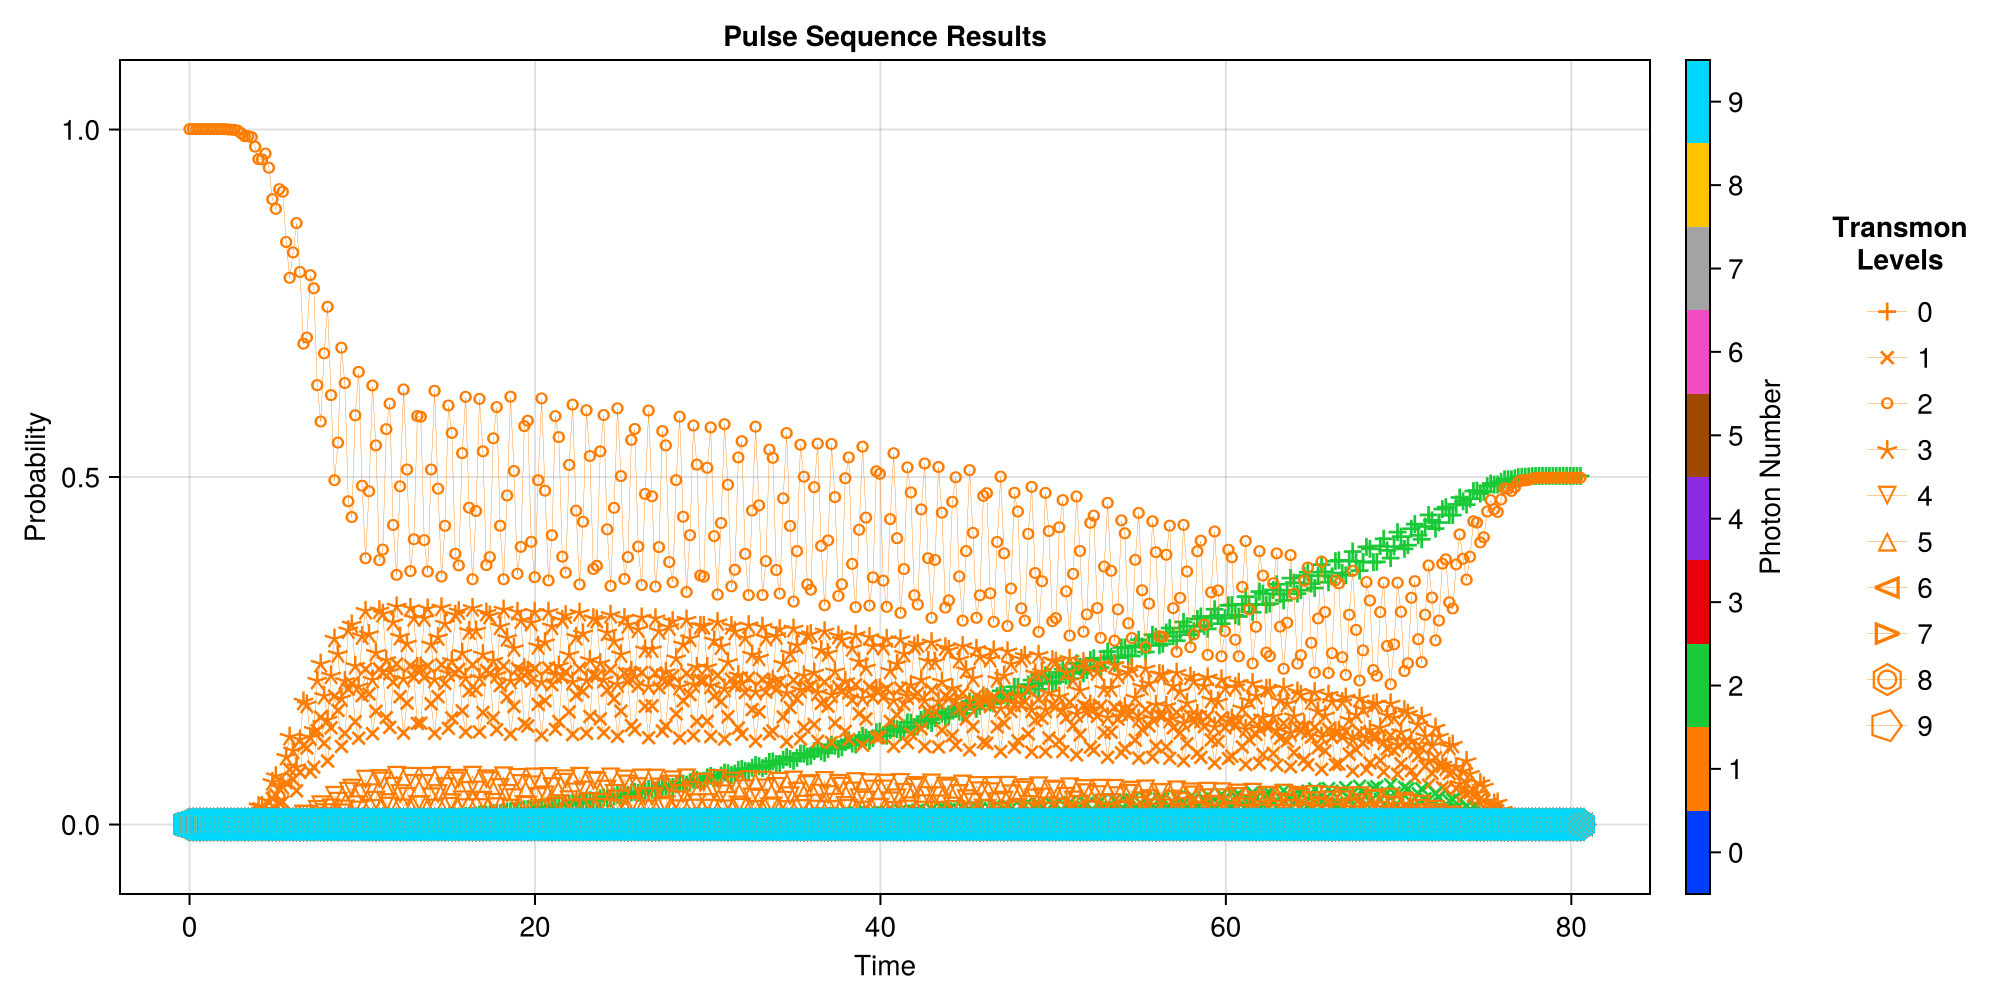

CairoMakie.Screen{IMAGE}


In [ ]:
SC.Dynamics.PlotSingleModeEvolution(Mode7, res_half_f1g2["times"], EVs_Dict)

In [58]:
println(EVs_Dict[(2,1)][end])
println(EVs_Dict[(0,2)][end])

0.49842784624199354 + 3.047257166760866e-18im
0.5015715525412404 - 3.656046931258164e-17im
